# <b>TrackML/HotelRank</b>: Elevating Revenue Performance Through Machine Learning and Deep Learning Techniques.

Revenue management is a very important to make profits in the hotel industry, three main factors play an important role to get it right:  
    <ol>
    <li>Hotel room demand over time (demand forecast).</li>
    <li>Prediction of booking cancellations.</li>
    <li>Online hotel reputation.</li>
    </ol>
In this project we take in account each one thru a linear combination of different scores that represent each item. Our customer, Blastnesss.com has provided the data. For customer requirement we give factors 1.5 to Hotel room demand, 0.8 to prediction of booking cancellations, 0.5 to Online reputation, so for business requirement we have:

$$ HotelRank = 1.5 * DemandScore + 0.8 * CancellationScore + 0.5 * ReviewScore + 0 * OtherEventsScore $$


Just to clarify:
- DemandScore : Model demand forecast.
- CancellationScore: Model booking cancellations.
- ReviewScore: Model online reputation.
- OtherEventsScore: Model external factors.




# <b>DemandScore</b>: Demand Forecast over 24 months booking.

The objective to section to concentrate ourselves to demand forecast with just Blastness dataset and nothing more:
- We have to clean the data provided and see patterns.
- Detect outliers in the demand score.
- Compare SARIMAX and prophet neural network to see which fits better for the demandscore.
- Create the demand score for each hotel using booking forecast in next temporal year frame.
- We leave to future work any crossdata about the demand related to weather and external events.

As first step for series forecasting we need to analyze

In [1]:
!pip install pandas numpy seaborn matplot scikit-learn pyarrow prophet statsmodels pycaret datasets prophet

## Data Cleaning

As first action we load the csv provided by [Blastness](https://www.blastness.com) and we create a dataset with columns names in English

In [2]:

import glob
import pandas as pd
pd.options.mode.copy_on_write = True
filelist = glob.glob('./hoteldataset/*.csv')
hotelsbookings = []
column_mapping = {
    'Codice': 'Code',
    'Status': 'Status',
    'Canale': 'BookingChannel',
    'Arrivo': 'Arrival',
    'Partenza': 'Departure',
    'Notti': 'Nights',
    'Totale': 'Total',
    'Data acquisto': 'PurchaseDate',
    'Dispositivo': 'BookingDevice',
    'Data Ultima Modifica/Cancellazione': 'LastModified'
}
for idx,f in enumerate(filelist):
    df = pd.read_csv(f)
    select_columns = list(column_mapping.keys())
    current_df = df[select_columns]
    remap = current_df.rename(columns=column_mapping)
    hotel_id = ""
    if idx < 9:
        hotel_id=f'00{idx+1}'
    else:
        hotel_id=f'0{idx+1}'

    remap['HotelId'] = hotel_id
    hotelsbookings.append(remap)
hotelsbookings[9].head()


/tmp/ipykernel_8167/4030294290.py:19: DtypeWarning: Columns (23,53,62,68,70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_8167/4030294290.py:19: DtypeWarning: Columns (23,52,55,58,59,60,81,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_8167/4030294290.py:19: DtypeWarning: Columns (23,49,55,59,81,87,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_8167/4030294290.py:19: DtypeWarning: Columns (23,52,53,55,58,59,60,62,68,70,81,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


Code      Status BookingChannel     Arrival   Departure  Nights  \
0  19887PMCMTT6  Cancellata           Sito  23/10/2021  30/10/2021       0   
1  19887FBFWGZ7  Confermata           Sito  31/07/2021  06/08/2021       6   
2  19887JIZNTR8  Confermata           Sito  23/10/2021  26/10/2021       3   
3  19887CNIHY10  Confermata           Sito  23/11/2022  28/11/2022       5   
4  19887GOAMJ11  Confermata           Sito  11/10/2022  15/10/2022       4   

     Total PurchaseDate BookingDevice         LastModified HotelId  
0     0,00   31/05/2021       Website  31/05/2021 17:37:31     010  
1  2894,25   08/07/2021       Website  08/07/2021 22:23:51     010  
2  2142,00   04/10/2021       Website  04/10/2021 21:24:49     010  
3  3696,00   01/06/2022       Website  01/06/2022 10:46:15     010  
4  4488,00   26/06/2022       Website  26/06/2022 04:14:05     010

Now we merge all hotels in a single dataframe and save to disk. We note that we need to divide cancelled and confirmed booking. Later since we want do forecast on the confirmed.
- Also we need to categorize the origin
- remove the booking device.

First we merge.

In [3]:
# Merge DataFrames
merged_df = pd.concat(hotelsbookings, ignore_index=True)
# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df)

Merged DataFrame:
                         Code      Status BookingChannel     Arrival  \
0       1400576136/1204413850  Cancellata    Booking.com  22/07/2017   
1       1240874198/1204820657  Cancellata    Booking.com  15/07/2017   
2       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
3       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
4       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
...                       ...         ...            ...         ...   
151852           19887FIHJR22  Confermata           Sito  19/10/2023   
151853           19887DOSJP23  Confermata           Sito  10/06/2023   
151854           19887KTDJJ24  Confermata           Sito  18/07/2023   
151855           19887LNQHJ25  Confermata           Sito  24/04/2023   
151856           19887IENNC26  Confermata           Sito  18/09/2023   

         Departure  Nights    Total PurchaseDate BookingDevice  \
0       29/07/2017       0     0,00   01/01/2017   

Ok, we've seen a lot of not known or bad data. Just clean it. We want order by date, in descending mode and take only the booking from 2019 to 2023. We might restrict further the dataset if it is needed.

In [4]:
merged_df.head()

Code      Status BookingChannel     Arrival   Departure  \
0  1400576136/1204413850  Cancellata    Booking.com  22/07/2017  29/07/2017   
1  1240874198/1204820657  Cancellata    Booking.com  15/07/2017  02/08/2017   
2  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   
3  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   
4  1656344835/1204828455  Cancellata    Booking.com  22/07/2017  09/08/2017   

   Nights Total PurchaseDate BookingDevice         LastModified HotelId  
0       0  0,00   01/01/2017           NaN  01/01/2017 15:27:39     001  
1       0  0,00   01/01/2017           NaN  01/01/2017 23:13:49     001  
2       0  0,00   01/01/2017           NaN  11/01/2017 21:59:16     001  
3       0  0,00   01/01/2017           NaN  10/01/2017 22:10:56     001  
4       0  0,00   01/01/2017           NaN  11/01/2017 21:59:16     001

In [5]:
merged_df['Arrival'] = pd.to_datetime(merged_df['Arrival'],dayfirst=True)
# Sorting by 'Arrival' column in descending order
sorted_bookings_df = merged_df.sort_values(by='Arrival', ascending=False)
# Filtering for HotelId '001'
filtered_df = sorted_bookings_df.loc[sorted_bookings_df['HotelId'] == '010']
filtered_df.head()

Code      Status BookingChannel    Arrival   Departure  \
151852  19887FIHJR22  Confermata           Sito 2023-10-19  22/10/2023   
151849  19887VFAUN19  Confermata           Sito 2023-09-26  28/09/2023   
151856  19887IENNC26  Confermata           Sito 2023-09-18  21/09/2023   
151850  19887VNOHO20  Confermata           Sito 2023-08-25  27/08/2023   
151847  19887AZGQK17  Confermata           Sito 2023-08-01  04/08/2023   

        Nights    Total PurchaseDate BookingDevice         LastModified  \
151852       3  3080,00   11/03/2023       Website  11/03/2023 10:15:06   
151849       2  1760,00   02/02/2023       Website  02/02/2023 16:43:04   
151856       3  3168,00   03/06/2023       Website  03/06/2023 12:55:03   
151850       2  1496,00   09/03/2023       Website  09/03/2023 20:00:03   
151847       3  1980,00   01/12/2022       Website  01/12/2022 18:41:16   

       HotelId  
151852     010  
151849     010  
151856     010  
151850     010  
151847     010

Now I convert datates to timestamps and check for null values.

In [6]:
# Filtering for HotelId '001'
nan_rows = sorted_bookings_df[sorted_bookings_df['Arrival'].isna()]
print("Rows with NaN in 'Arrival':", len(nan_rows))
nan_rows = sorted_bookings_df[sorted_bookings_df['Departure'].isna()]
print("Rows with NaN in 'Departure':", len(nan_rows))
# conversion in datetime
sorted_bookings_df['Arrival'] = pd.to_datetime(sorted_bookings_df['Arrival'], errors='coerce', dayfirst=True)
sorted_bookings_df['Departure'] = pd.to_datetime(sorted_bookings_df['Departure'], errors='coerce', dayfirst=True)
sorted_bookings_df['LastModified'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce', dayfirst=True)
sorted_bookings_df['PurchaseDate'] = pd.to_datetime(sorted_bookings_df['PurchaseDate'], errors='coerce', dayfirst=True)
# we want to make sure that are numerical data
sorted_bookings_df['Total'] = sorted_bookings_df['Total'].str.replace(',', '.').astype(float)
sorted_bookings_df['Total'] = pd.to_numeric(sorted_bookings_df['Total'])
sorted_bookings_df['Nights'] = pd.to_numeric(sorted_bookings_df['Nights'])
# add timestamp
sorted_bookings_df['Arrival_Timestamp'] = sorted_bookings_df['Arrival'].astype('int64')
sorted_bookings_df['Departure_Timestamp'] = sorted_bookings_df['Departure'].astype('int64')
sorted_bookings_df['LastModified_Timestamp'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce')
sorted_bookings_df['Purchase_Timestamp'] = sorted_bookings_df['PurchaseDate'].astype('int64')
sorted_bookings_df.head()



Rows with NaN in 'Arrival': 0
Rows with NaN in 'Departure': 0


Code      Status BookingChannel    Arrival  Departure  \
20758           H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
20757           A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
20680           B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
20693           R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
60317  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
20758       3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     004   
20757       0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     004   
20680       0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     004   
20693       0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     004   
60317       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
20758  1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
20757  1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
20680  1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
20693  1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
60317  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp  
20758  1687392000000000000  
20757  1687392000000000000  
20680  1686787200000000000  
20693  1686960000000000000  
60317  1678838400000000000

We want to add the city to he dataset the client has provided the following mapping:
```
hotel_to_city = {
    '001': "Rome, Italy",
    '002': "Naples, Italy",
    '003': "Florence, Italy",
    '004': "Florence, Italy",
    '005': "Naples, Italy",
    '006': "Brindisi, Italy",
    '007': "Latina, Italy",
    '008': "Olbia, Sardinia, Italy",
    '009': "Chamonix-Mont-Blanc, France",
    '010': "Rome, Italy",
}
```
So we can have a complete a dataset to correlate in future with events, weather and so on.

In [7]:
coordinate_to_city = {
    '001': "Rome",
    '002': "Naples",
    '003': "Florence",
    '004': "Florence",
    '005': "Naples",
    '006': "Brindisi",
    '007': "Latina",
    '008': "Olbia",
    '009': "Chamonix-Mont-Blanc",
    '010': "Rome",
}

# Function to get the city name based on HotelId
def get_city(hotel_id):
    return coordinate_to_city.get(hotel_id, "Unknown")

# Add the City column based on the HotelId
sorted_bookings_df['City'] = sorted_bookings_df['HotelId'].apply(get_city)

We want also add the season because we know from the domain the booking changes of season and when the booking device is not known.

In [8]:
# we clean unknown
sorted_bookings_df['BookingDevice'].fillna('Unknown', inplace=True)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
sorted_bookings_df['Season'] = sorted_bookings_df['Arrival'].apply(get_season)
sorted_bookings_df.head()



Code      Status BookingChannel    Arrival  Departure  \
20758           H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
20757           A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
20680           B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
20693           R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
60317  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
20758       3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     004   
20757       0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     004   
20680       0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     004   
20693       0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     004   
60317       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
20758  1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
20757  1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
20680  1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
20693  1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
60317  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp      City  Season  
20758  1687392000000000000  Florence  Spring  
20757  1687392000000000000  Florence  Spring  
20680  1686787200000000000  Florence  Spring  
20693  1686960000000000000  Florence  Spring  
60317  1678838400000000000  Brindisi  Spring

Now before going further and doing descriptive statistics we neeed to know is there are still NaN. It is ok we store for future purposes the dataset in parquet file. 

In [9]:
# Check if any row in any column is NaN
has_nan = sorted_bookings_df.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
# Display rows with any NaN values
rows_with_nan = sorted_bookings_df[sorted_bookings_df.isna().any(axis=1)]
print("Rows with NaN values:")
rows_with_nan.head()


Does the DataFrame contain any NaN values? True
Rows with NaN values:


Code      Status BookingChannel    Arrival  Departure  \
60317  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   
60316  2262350217/4142372765  Cancellata    Booking.com 2024-03-30 2024-04-06   
60315  2694489967/4142285639  Cancellata    Booking.com 2024-03-30 2024-04-06   
60754  3250233143/4271797361  Cancellata    Booking.com 2024-03-29 2024-04-01   
60753  3250233143/4271797361  Confermata    Booking.com 2024-03-28 2024-03-31   

       Nights  Total PurchaseDate BookingDevice        LastModified HotelId  \
60317       0    0.0   2023-03-15           NaN 2023-03-15 21:44:16     006   
60316       0    0.0   2023-03-15           NaN 2023-03-15 21:22:16     006   
60315       0    0.0   2023-03-15           NaN 2023-03-15 20:31:35     006   
60754       0    0.0   2023-05-28           NaN 2023-05-28 13:55:50     006   
60753       3  661.5   2023-05-28           NaN 2023-05-28 13:55:50     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
60317  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   
60316  1711756800000000000  1712361600000000000    2023-03-15 21:22:16   
60315  1711756800000000000  1712361600000000000    2023-03-15 20:31:35   
60754  1711670400000000000  1711929600000000000    2023-05-28 13:55:50   
60753  1711584000000000000  1711843200000000000    2023-05-28 13:55:50   

        Purchase_Timestamp      City  Season  
60317  1678838400000000000  Brindisi  Spring  
60316  1678838400000000000  Brindisi  Spring  
60315  1678838400000000000  Brindisi  Spring  
60754  1685232000000000000  Brindisi  Spring  
60753  1685232000000000000  Brindisi  Spring

Ok. We've seen that the booking channel can be a valid string or Unknown. The other thing that we want is to the hotel booking for a fixed period from 2024 to 2022. After this we can 

In [10]:
sorted_bookings_df['BookingChannel'] = sorted_bookings_df['BookingChannel'].fillna('Unknown')
sorted_bookings_df.head()


Code      Status BookingChannel    Arrival  Departure  \
20758           H6382AEX6419  Confermata           Sito 2024-05-05 2024-05-08   
20757           A6382VHL6418  Cancellata           Sito 2024-05-05 2024-05-08   
20680           B6382JWZ6342  Cancellata           Sito 2024-05-05 2024-05-08   
20693           R6382UMZ6352  Cancellata           Sito 2024-05-04 2024-05-08   
60317  2285145742/4142410564  Cancellata    Booking.com 2024-03-30 2024-04-06   

       Nights   Total PurchaseDate BookingDevice        LastModified HotelId  \
20758       3  1010.0   2023-06-22       Website 2023-06-22 19:53:46     004   
20757       0     0.0   2023-06-22        Mobile 2023-06-22 19:07:31     004   
20680       0     0.0   2023-06-15        Mobile 2023-06-15 21:12:34     004   
20693       0     0.0   2023-06-17        Mobile 2023-06-17 05:21:46     004   
60317       0     0.0   2023-03-15           NaN 2023-03-15 21:44:16     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
20758  1714867200000000000  1715126400000000000    2023-06-22 19:53:46   
20757  1714867200000000000  1715126400000000000    2023-06-22 19:07:31   
20680  1714867200000000000  1715126400000000000    2023-06-15 21:12:34   
20693  1714780800000000000  1715126400000000000    2023-06-17 05:21:46   
60317  1711756800000000000  1712361600000000000    2023-03-15 21:44:16   

        Purchase_Timestamp      City  Season  
20758  1687392000000000000  Florence  Spring  
20757  1687392000000000000  Florence  Spring  
20680  1686787200000000000  Florence  Spring  
20693  1686960000000000000  Florence  Spring  
60317  1678838400000000000  Brindisi  Spring

Now I want to restrict the timing interval between 2020 and 2023 because later we'll do series forecast and we wnat to reduce the risk of [data snooping] (https://datascience.stanford.edu/news/data-snooping).


In [11]:
start_date = '2020-01-01'
end_date = '2023-12-31'
sorted_bookings_df.head()
datetime_columns = ['Arrival', 'Departure', 'PurchaseDate', 'LastModified']
for col in datetime_columns:
    sorted_bookings_df[col] = pd.to_datetime(sorted_bookings_df[col])
hb_dataset = sorted_bookings_df[(sorted_bookings_df['Arrival'] >= start_date) & (sorted_bookings_df['Arrival'] <= end_date)] 
# Check if any row in any column is NaN
has_nan = hb_dataset.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
if has_nan:
# Display rows with any NaN values
    rows_with_nan = hb_dataset[hb_dataset.isna().any(axis=1)]
    print("Rows with NaN values:")
    rows_with_nan.head()
else:
    print('The dataset is ready some descriptivre statistics')

Does the DataFrame contain any NaN values? True
Rows with NaN values:


In [12]:
# Save the filtered DataFrame to a Parquet file
parquet_file = 'filtered_data.parquet'
hb_dataset.to_parquet(parquet_file)
print(f"Filtered DataFrame saved to {parquet_file}")

Filtered DataFrame saved to filtered_data.parquet


In [13]:
hb_dataset.head(10)

Code      Status BookingChannel    Arrival  Departure  \
60820  2493115910/4283897556  Confermata    Booking.com 2023-12-28 2024-01-04   
60923  2745673363/4308678121  Confermata    Booking.com 2023-12-27 2024-01-03   
61034  3958853713/4337114239  Confermata    Booking.com 2023-12-26 2024-01-02   
60873  3854867487/4296773334  Confermata    Booking.com 2023-12-26 2024-01-02   
60750  2359160563/4271754038  Confermata    Booking.com 2023-12-23 2023-12-31   
60751  2359160563/4271754066  Confermata    Booking.com 2023-12-23 2023-12-31   
60752  2359160563/4271754047  Confermata    Booking.com 2023-12-23 2023-12-31   
60035  2165812668/4071186490  Confermata    Booking.com 2023-12-23 2023-12-30   
60034  2165812668/4071186490  Cancellata    Booking.com 2023-12-23 2023-12-30   
60728  3626349779/4266644156  Confermata    Booking.com 2023-12-22 2023-12-29   

       Nights    Total PurchaseDate BookingDevice        LastModified HotelId  \
60820       7  4637.25   2023-06-04           NaN 2023-06-04 09:27:30     006   
60923       7  3892.05   2023-06-17           NaN 2023-06-17 18:09:53     006   
61034       7  2766.15   2023-07-02           NaN 2023-07-02 16:35:28     006   
60873       7  2620.35   2023-06-11           NaN 2023-06-11 10:53:57     006   
60750       8  2997.00   2023-05-28           NaN 2023-05-28 13:16:41     006   
60751       8  3240.00   2023-05-28           NaN 2023-05-28 13:16:41     006   
60752       8  3126.60   2023-05-28           NaN 2023-05-28 13:16:41     006   
60035       7  3154.50   2023-02-03           NaN 2023-05-10 23:21:21     006   
60034       0     0.00   2023-02-03           NaN 2023-05-10 23:21:21     006   
60728       7  3001.50   2023-05-25           NaN 2023-05-25 10:41:31     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
60820  1703721600000000000  1704326400000000000    2023-06-04 09:27:30   
60923  1703635200000000000  1704240000000000000    2023-06-17 18:09:53   
61034  1703548800000000000  1704153600000000000    2023-07-02 16:35:28   
60873  1703548800000000000  1704153600000000000    2023-06-11 10:53:57   
60750  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
60751  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
60752  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   
60035  1703289600000000000  1703894400000000000    2023-05-10 23:21:21   
60034  1703289600000000000  1703894400000000000    2023-05-10 23:21:21   
60728  1703203200000000000  1703808000000000000    2023-05-25 10:41:31   

        Purchase_Timestamp      City  Season  
60820  1685836800000000000  Brindisi  Winter  
60923  1686960000000000000  Brindisi  Winter  
61034  1688256000000000000  Brindisi  Winter  
60873  1686441600000000000  Brindisi  Winter  
60750  1685232000000000000  Brindisi  Winter  
60751  1685232000000000000  Brindisi  Winter  
60752  1685232000000000000  Brindisi  Winter  
60035  1675382400000000000  Brindisi  Winter  
60034  1675382400000000000  Brindisi  Winter  
60728  1684972800000000000  Brindisi  Winter

We begin by analyzing and understanding the categorical variables "Status" and "Booking Devices" and applying an Ordinal Encoder for their transformation. For the "Status" category, we anticipate the following values: Confermata (Confirmed), Cancellata (Cancelled), and Modificata (Modified). This encoding will later be instrumental in calculating the cancellation score.

In [14]:
hb_dataset['Status'].unique()

array(['Confermata', 'Cancellata', 'Modificata'], dtype=object)

In [15]:
hb_dataset['BookingDevice'].unique()

array([nan, 'Mobile', 'Website', 'Tablet'], dtype=object)

In [16]:
from sklearn.preprocessing import OrdinalEncoder
status_categories = hb_dataset[['Status']]
device_categories = hb_dataset[['BookingDevice']]
ordinal_encoder = OrdinalEncoder()
hb_dataset_booking_cat = ordinal_encoder.fit_transform(status_categories).copy()
hb_dataset_booking_device = ordinal_encoder.fit_transform(device_categories).copy()
hb_dataset['Status'] = hb_dataset_booking_cat
hb_dataset['BookingDevice'] = hb_dataset_booking_device
hb_dataset.head(10)

Code  Status BookingChannel    Arrival  Departure  \
60820  2493115910/4283897556     1.0    Booking.com 2023-12-28 2024-01-04   
60923  2745673363/4308678121     1.0    Booking.com 2023-12-27 2024-01-03   
61034  3958853713/4337114239     1.0    Booking.com 2023-12-26 2024-01-02   
60873  3854867487/4296773334     1.0    Booking.com 2023-12-26 2024-01-02   
60750  2359160563/4271754038     1.0    Booking.com 2023-12-23 2023-12-31   
60751  2359160563/4271754066     1.0    Booking.com 2023-12-23 2023-12-31   
60752  2359160563/4271754047     1.0    Booking.com 2023-12-23 2023-12-31   
60035  2165812668/4071186490     1.0    Booking.com 2023-12-23 2023-12-30   
60034  2165812668/4071186490     0.0    Booking.com 2023-12-23 2023-12-30   
60728  3626349779/4266644156     1.0    Booking.com 2023-12-22 2023-12-29   

       Nights    Total PurchaseDate  BookingDevice        LastModified  \
60820       7  4637.25   2023-06-04            NaN 2023-06-04 09:27:30   
60923       7  3892.05   2023-06-17            NaN 2023-06-17 18:09:53   
61034       7  2766.15   2023-07-02            NaN 2023-07-02 16:35:28   
60873       7  2620.35   2023-06-11            NaN 2023-06-11 10:53:57   
60750       8  2997.00   2023-05-28            NaN 2023-05-28 13:16:41   
60751       8  3240.00   2023-05-28            NaN 2023-05-28 13:16:41   
60752       8  3126.60   2023-05-28            NaN 2023-05-28 13:16:41   
60035       7  3154.50   2023-02-03            NaN 2023-05-10 23:21:21   
60034       0     0.00   2023-02-03            NaN 2023-05-10 23:21:21   
60728       7  3001.50   2023-05-25            NaN 2023-05-25 10:41:31   

      HotelId    Arrival_Timestamp  Departure_Timestamp  \
60820     006  1703721600000000000  1704326400000000000   
60923     006  1703635200000000000  1704240000000000000   
61034     006  1703548800000000000  1704153600000000000   
60873     006  1703548800000000000  1704153600000000000   
60750     006  1703289600000000000  1703980800000000000   
60751     006  1703289600000000000  1703980800000000000   
60752     006  1703289600000000000  1703980800000000000   
60035     006  1703289600000000000  1703894400000000000   
60034     006  1703289600000000000  1703894400000000000   
60728     006  1703203200000000000  1703808000000000000   

      LastModified_Timestamp   Purchase_Timestamp      City  Season  
60820    2023-06-04 09:27:30  1685836800000000000  Brindisi  Winter  
60923    2023-06-17 18:09:53  1686960000000000000  Brindisi  Winter  
61034    2023-07-02 16:35:28  1688256000000000000  Brindisi  Winter  
60873    2023-06-11 10:53:57  1686441600000000000  Brindisi  Winter  
60750    2023-05-28 13:16:41  1685232000000000000  Brindisi  Winter  
60751    2023-05-28 13:16:41  1685232000000000000  Brindisi  Winter  
60752    2023-05-28 13:16:41  1685232000000000000  Brindisi  Winter  
60035    2023-05-10 23:21:21  1675382400000000000  Brindisi  Winter  
60034    2023-05-10 23:21:21  1675382400000000000  Brindisi  Winter  
60728    2023-05-25 10:41:31  1684972800000000000  Brindisi  Winter

## Descriptive statistics

In this section we need a basic descriptive statistics.


In [17]:
descriptive_stats = hb_dataset.describe()
# we will use later for compute the score
canc_score_compute = hb_dataset.copy()
print("\nDescriptive Statistics for numeric columns in the filtered DataFrame:")
print(descriptive_stats)
descriptive_stats_all = hb_dataset.describe(include='all')
print("\nDescriptive Statistics for all columns in the filtered DataFrame:")
print(descriptive_stats_all)


Descriptive Statistics for numeric columns in the filtered DataFrame:
             Status        Nights         Total  BookingDevice  \
count  39340.000000  39340.000000  39340.000000    6280.000000   
mean       0.589553      1.516548    396.177232       1.513376   
std        0.525452      1.967660    667.932308       0.847213   
min        0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      0.000000       1.000000   
50%        1.000000      1.000000    144.900000       2.000000   
75%        1.000000      2.000000    531.000000       2.000000   
max        2.000000     30.000000  20124.000000       2.000000   

       Arrival_Timestamp  Departure_Timestamp  Purchase_Timestamp  
count       3.934000e+04         3.934000e+04        3.934000e+04  
mean        1.642224e+18         1.642482e+18        1.636262e+18  
std         3.238879e+16         3.238956e+16        3.338754e+16  
min         1.577837e+18         1.577923e+18        1.553213e

/tmp/ipykernel_8167/835808718.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all = hb_dataset.describe(include='all')
/tmp/ipykernel_8167/835808718.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all = hb_dataset.describe(include='all')
/tmp/ipykernel_8167/835808718.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all = hb_

In [18]:
hb_dataset.isnull().sum()

Code                          0
Status                        0
BookingChannel                0
Arrival                       0
Departure                     0
Nights                        0
Total                         0
PurchaseDate                  0
BookingDevice             33060
LastModified                  0
HotelId                       0
Arrival_Timestamp             0
Departure_Timestamp           0
LastModified_Timestamp        0
Purchase_Timestamp            0
City                          0
Season                        0
dtype: int64

We know that:
- We've 39345 booking in the period.
- The average staying is 1.6 days for each booking.
- The medium booking revenue is 370 euros.
- We have to drop BookingDevice.

In [19]:
hb_dataset.drop(columns=['BookingDevice'], inplace=True)

That's not enough, we want to know:
- How frequent is a booking?
- Which between our customers how had most revenue?
- Which has most room booked and and in which city?
- Which is the season in which we've most rooom booked? 

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

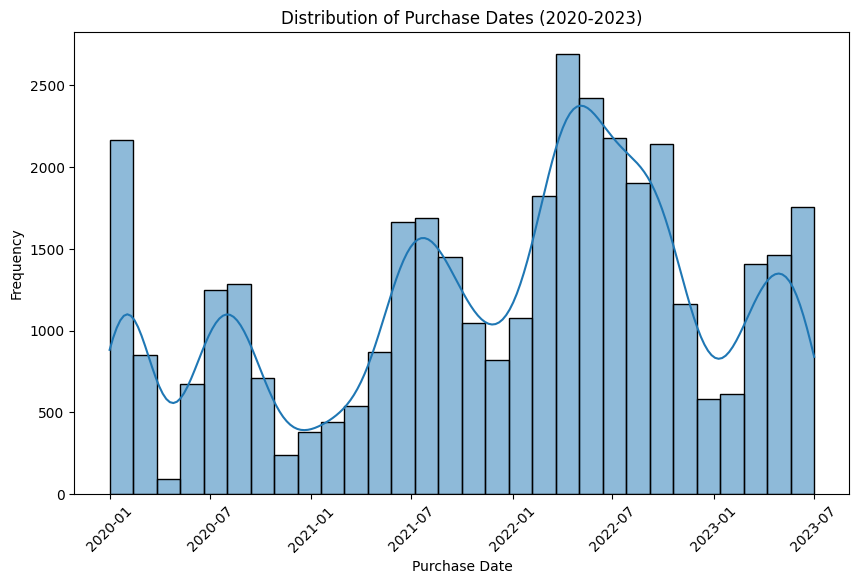

In [21]:
start_date = '2020-01-01'
end_date = '2023-12-31'
filtered_df = hb_dataset[(hb_dataset['PurchaseDate'] >= start_date) & (hb_dataset['PurchaseDate'] <= end_date)]

# Plot the distribution of purchase dates using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['PurchaseDate'], kde=True, bins=30)
plt.xlabel('Purchase Date')
plt.ylabel('Frequency')
plt.title('Distribution of Purchase Dates (2020-2023)')
plt.xticks(rotation=45)
plt.show()

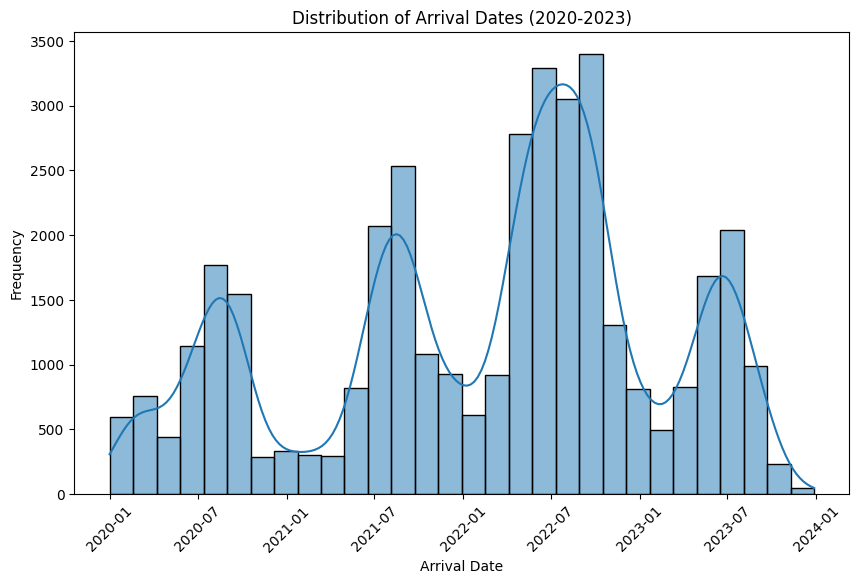

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['Arrival'], kde=True, bins=30)
plt.xlabel('Arrival Date')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Dates (2020-2023)')
plt.xticks(rotation=45)
plt.show()

Make sense. Most booking are at the beginning of the year and just before summer. Italians tends to go in vacation on August so in July the book. Our goal is to see if there is seasonality or it is [cyclic pattern](https://robjhyndman.com/hyndsight/cyclicts). Each year show us the same behaviour in terms of booking.

  Distribution  KS Statistic  P-Value
0         norm      0.106293      0.0
1        expon      0.277902      0.0
2        gamma      0.113996      0.0
3      lognorm      0.106295      0.0
4         beta      0.137298      0.0


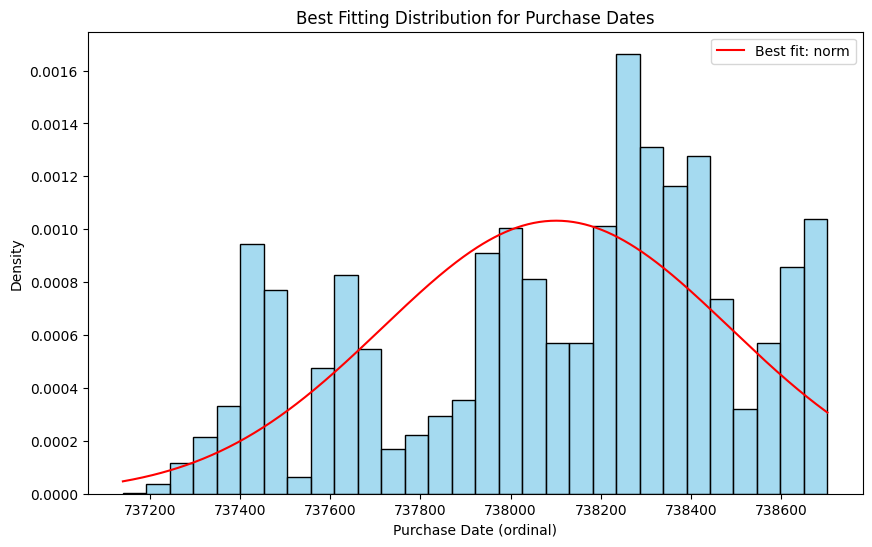

In [23]:

purchase_dates = hb_dataset['PurchaseDate'].apply(lambda x: x.toordinal())

distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(purchase_dates)
    ks_stat, p_value = stats.kstest(purchase_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(purchase_dates)

plt.figure(figsize=(10, 6))
sns.histplot(purchase_dates, kde=False, bins=30, color='skyblue', stat='density')

x = np.linspace(min(purchase_dates), max(purchase_dates), 500)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Purchase Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Purchase Dates')
plt.legend()
plt.show()


Some other studies have been found that a normal distribution model quite well also arrival: https://www.sciencedirect.com/science/article/abs/pii/S0261517717302431


  Distribution  KS Statistic  P-Value
0         norm      0.118242      0.0
1        expon      0.253936      0.0
2        gamma      0.126179      0.0
3      lognorm      0.118242      0.0
4         beta      0.109427      0.0


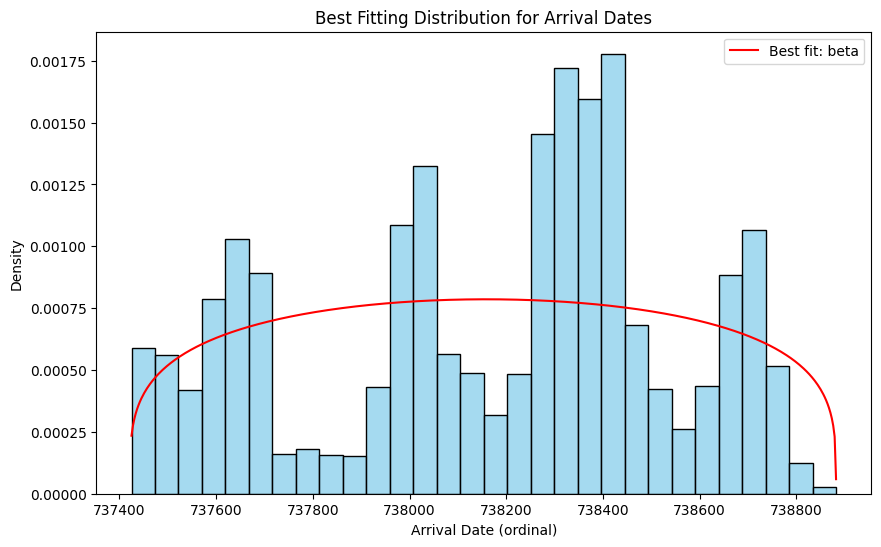

In [24]:
arrival_dates = hb_dataset['Arrival'].apply(lambda x: x.toordinal())

# List of distributions to check
distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

# Fit distributions and calculate KS statistic
results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(arrival_dates)
    ks_stat, p_value = stats.kstest(arrival_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

# Print results
results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

# Plot the best fitting distribution
best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(arrival_dates)

# Plot histogram and fitted distribution
plt.figure(figsize=(10, 6))
sns.histplot(arrival_dates, kde=False, bins=30, color='skyblue', stat='density')

# Plot the PDF of the best fitting distribution
x = np.linspace(min(arrival_dates), max(arrival_dates), 500)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Arrival Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Arrival Dates')
plt.legend()
plt.show()

Here the seasonality is quite evident.

## Which between our customers had most revenue?

In [25]:

revenue_per_hotel = hb_dataset.groupby(['HotelId', 'City'])['Total'].sum().reset_index()
revenue_per_hotel.sort_values(['Total'], inplace=True, ascending=False)
revenue_per_hotel.head()


HotelId      City       Total
7     008     Olbia  6398486.80
5     006  Brindisi  2418291.75
3     004  Florence  1808414.24
6     007    Latina  1606252.54
4     005    Naples  1545058.55

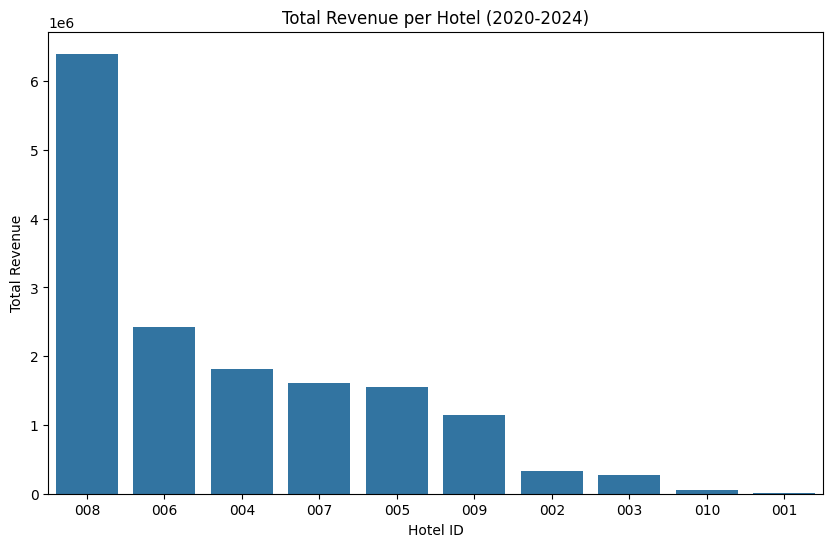

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x='HotelId', y='Total', data=revenue_per_hotel)
plt.xlabel('Hotel ID')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Hotel (2020-2024)')
plt.show()

Now we want to see in the dataset the correlation between data, but for doing this and reaching the correlation matrix we need to reduce the 
features, distiguish between categorical and numerical and doing one shot encoding, removing redundant features. We will take, our best customer as sample to develop the metodology that can be applied to the others. So Hotel008 is the most interesting client, we took as example to study our demand and generalize the algorithm to other customers.

In [27]:

# Identify numerical and categorical columns
numerical_cols = hb_dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = hb_dataset.select_dtypes(include=['object']).columns
# Drop unnecessary columns
corr_df = hb_dataset.drop(columns=['Code', 'Arrival', 'Departure', 'PurchaseDate', 'LastModified'])
# One-hot encoding of categorical columns using pd.get_dummies
df_encoded = pd.get_dummies(corr_df, drop_first=True)
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()
# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

/tmp/ipykernel_8167/528204745.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_encoded.corr()


Correlation Matrix:
                       Status    Nights     Total  Arrival_Timestamp  \
Status               1.000000  0.645211  0.513571           0.178381   
Nights               0.645211  1.000000  0.794623           0.156894   
Total                0.513571  0.794623  1.000000           0.198652   
Arrival_Timestamp    0.178381  0.156894  0.198652           1.000000   
Departure_Timestamp  0.177377  0.159126  0.200500           0.999982   
...                       ...       ...       ...                ...   
City_Olbia           0.053674 -0.019742  0.183897          -0.007913   
City_Rome            0.012441  0.031340  0.039968          -0.018450   
Season_Spring       -0.052579 -0.072694 -0.078285          -0.003985   
Season_Summer        0.038156  0.090853  0.060638           0.050297   
Season_Winter       -0.061001 -0.022598 -0.021612          -0.154265   

                     Departure_Timestamp  Purchase_Timestamp  \
Status                          0.177377           

As expected some things are evident:
- Rome is the city with higher possible revenue having an high correlation with Price.
- Purchase Date and Arrival Date are correlated.
Less evident is the behaviour for Season and the cities:
- Expected behaviour that Olbia is overcrowded in Summer, since it is in Sardinia. 
For our purpose, compute demandscore is enough since we select just Arrival and treat the dataset like a time series.
Now we will focus in model selection based on Arrival since our goal is to compute the demand score per hotel.
There are two algorithms:
    - Prophet
    -  SARIMAX

We'll see which is the best one for this dataset and we compute the score but first we need to detect anomalies for time series. Before we need to see if data contains anomalies and treat them. SARIMAX works only stationary series. Other approaches include using LSTM. XGBoost.


In [28]:
hb_dataset.head()

Code  Status BookingChannel    Arrival  Departure  \
60820  2493115910/4283897556     1.0    Booking.com 2023-12-28 2024-01-04   
60923  2745673363/4308678121     1.0    Booking.com 2023-12-27 2024-01-03   
61034  3958853713/4337114239     1.0    Booking.com 2023-12-26 2024-01-02   
60873  3854867487/4296773334     1.0    Booking.com 2023-12-26 2024-01-02   
60750  2359160563/4271754038     1.0    Booking.com 2023-12-23 2023-12-31   

       Nights    Total PurchaseDate        LastModified HotelId  \
60820       7  4637.25   2023-06-04 2023-06-04 09:27:30     006   
60923       7  3892.05   2023-06-17 2023-06-17 18:09:53     006   
61034       7  2766.15   2023-07-02 2023-07-02 16:35:28     006   
60873       7  2620.35   2023-06-11 2023-06-11 10:53:57     006   
60750       8  2997.00   2023-05-28 2023-05-28 13:16:41     006   

         Arrival_Timestamp  Departure_Timestamp LastModified_Timestamp  \
60820  1703721600000000000  1704326400000000000    2023-06-04 09:27:30   
60923  1703635200000000000  1704240000000000000    2023-06-17 18:09:53   
61034  1703548800000000000  1704153600000000000    2023-07-02 16:35:28   
60873  1703548800000000000  1704153600000000000    2023-06-11 10:53:57   
60750  1703289600000000000  1703980800000000000    2023-05-28 13:16:41   

        Purchase_Timestamp      City  Season  
60820  1685836800000000000  Brindisi  Winter  
60923  1686960000000000000  Brindisi  Winter  
61034  1688256000000000000  Brindisi  Winter  
60873  1686441600000000000  Brindisi  Winter  
60750  1685232000000000000  Brindisi  Winter

## Anomalies exploration in the dataset from the point of view time series.

In [29]:
demand = hb_dataset.groupby(['HotelId','Arrival']).size().reset_index(name='BookingCount')
demand.head()

HotelId    Arrival  BookingCount
0     001 2020-05-23             1
1     001 2020-05-24             1
2     001 2020-05-29             1
3     001 2020-06-13             3
4     001 2020-07-18             1

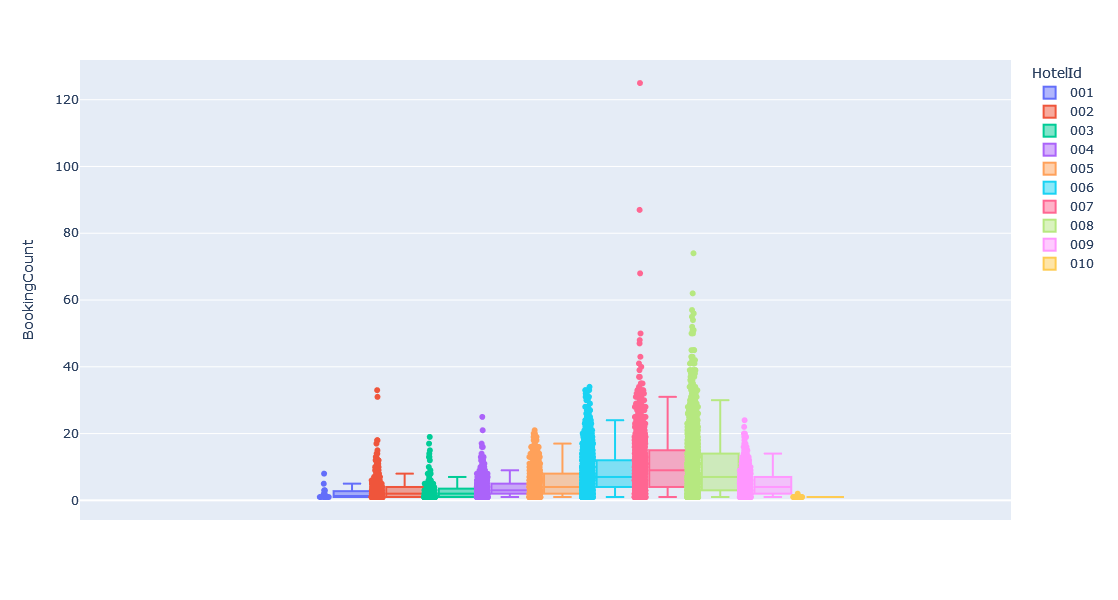

In [30]:

import plotly.express as px
fig = px.box(demand, y="BookingCount", color='HotelId', points='all',  width=800, height=600)
fig.show()


We use this diagram to assist with interpreting the boxplot:  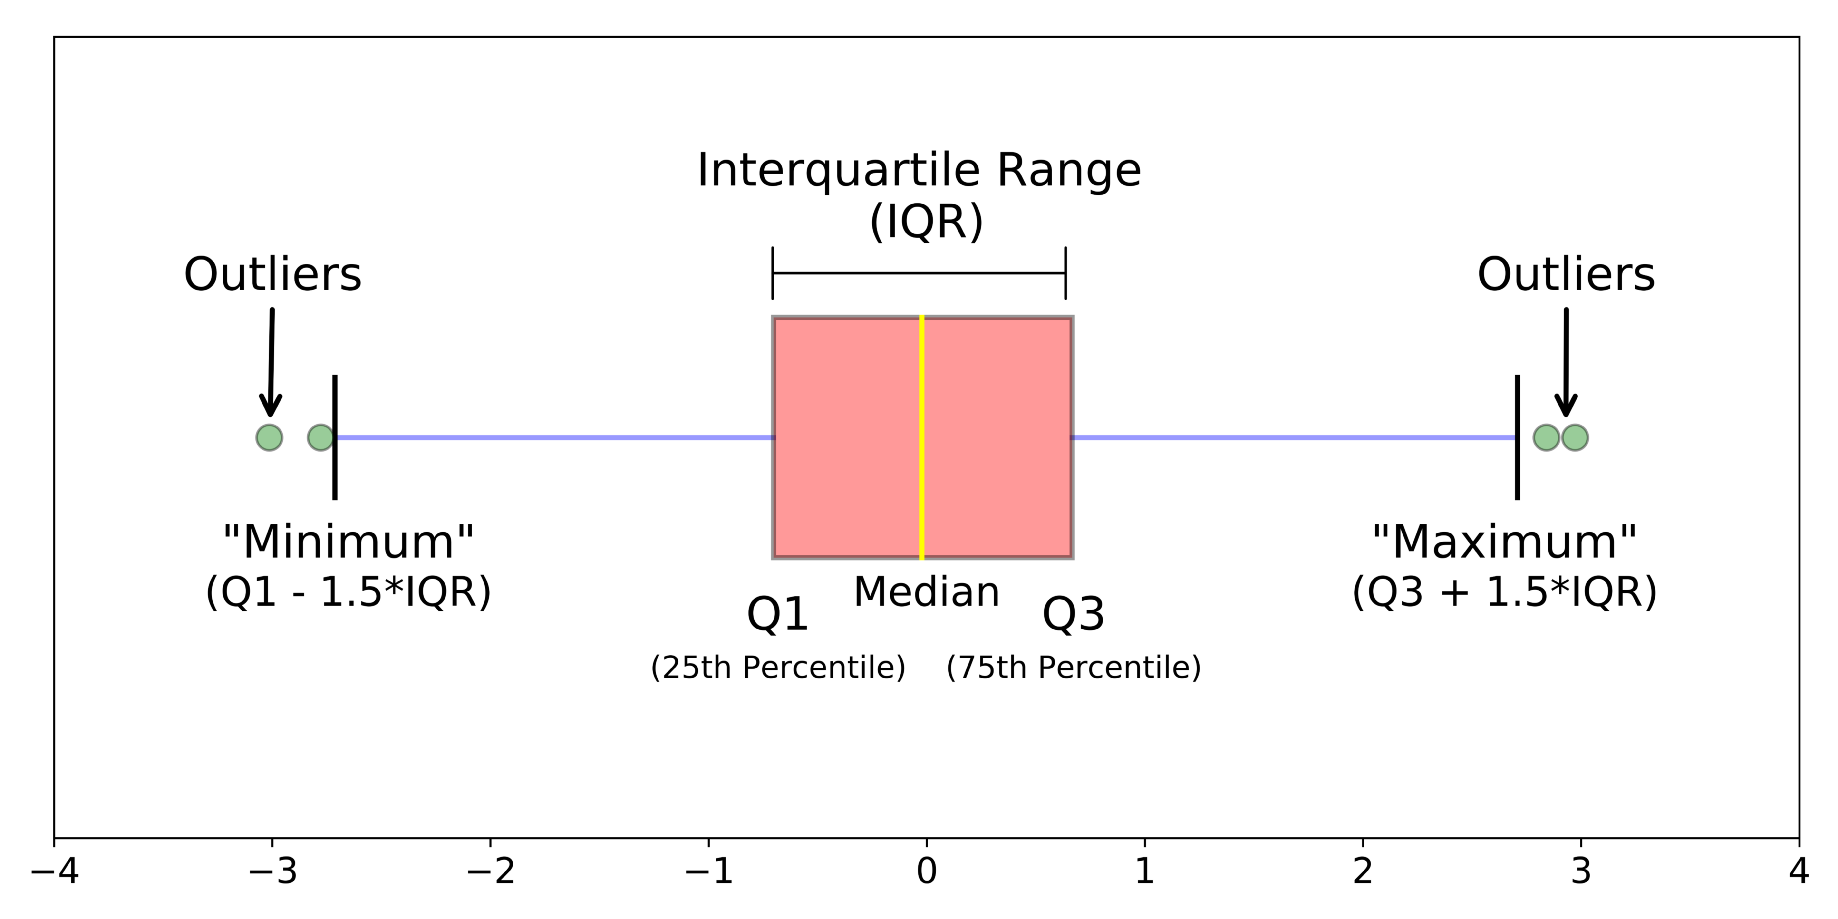 This comes from the bloog [Towards Data Science](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd5)
So using that model, there are hotel that have values that are candidate outliers in the time series distribution. Let's try to isolate the box plot and the booking per week per hotel.

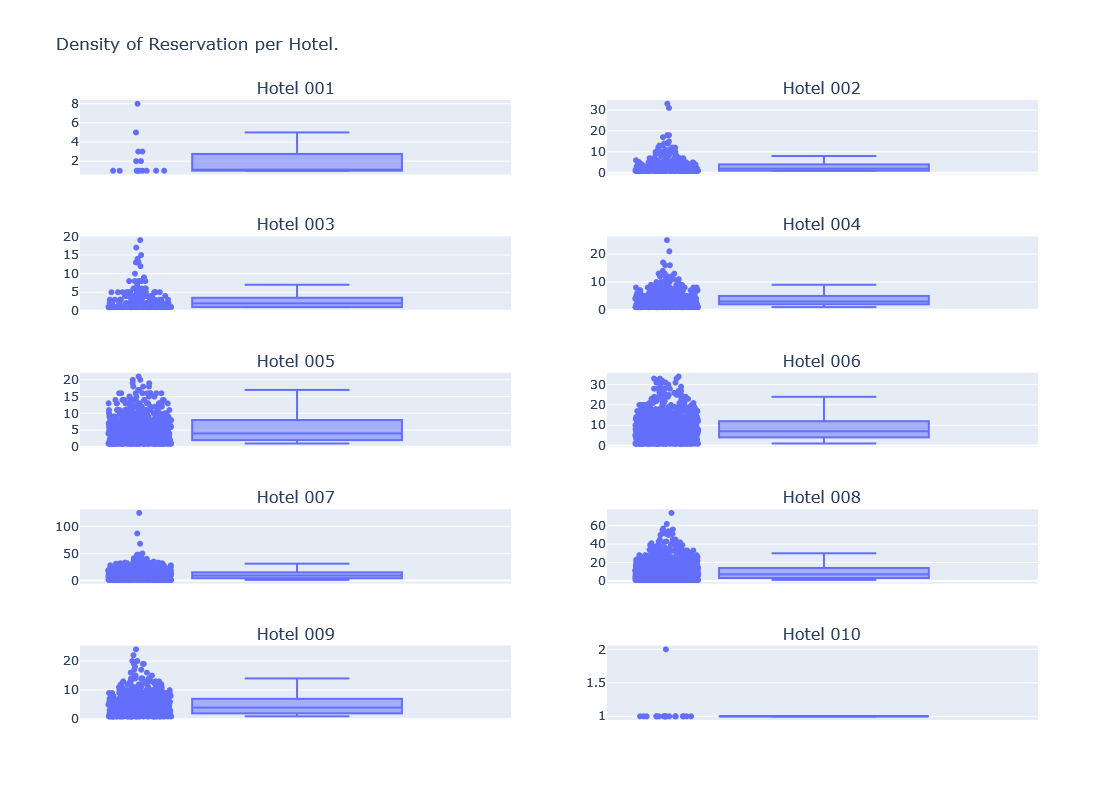

In [31]:

import plotly.express as px
from plotly.subplots import make_subplots

hotel_ids = demand['HotelId'].unique()
rows = (len(hotel_ids) + 1) // 2  # Calculate the number of rows needed
fig = make_subplots(rows=rows, cols=2, subplot_titles=[f'Hotel {hotel_id}' for hotel_id in hotel_ids])
for idx, hotel_id in enumerate(hotel_ids):
    hotel_data = demand[demand['HotelId'] == hotel_id]    
    box_plot = px.box(hotel_data, y="BookingCount", points='all')
    for trace in box_plot['data']:
        fig.add_trace(trace, row=(idx // 2) + 1, col=(idx % 2) + 1)
fig.update_layout(height=800, width=1000, showlegend=False, title_text="Density of Reservation per Hotel.")
fig.show()


The comprensive set of boxplot indicates that in each hotel there weeks that we've exceptional demand i.e. in Summer for each Hotel or it can be anomalies 
to be detected. We use an algorithm that comes a well known Italian university but at the moment let's understand seasonal decomposition. We pick up HotelId 008 because it is our most important customer in term or revenue and it is also the one that has more anomalies.

## Seasonal Decomposition
Seasonal decompositon will fundamental for our algorithm. In this [decomposition](https://math.unm.edu/~lil/Stat581/6-decomposition.pdf) a time series is split on three parts:
1. Trend: Long term pattern present in the series both increase or decrease.
2. Seasonal: Repeating cyclic pattern in the series where the cycle is specified in weeks, months, years.
3. Residual: Basically noise. It is the remaining part of the data after removing the trend and seasonal components.

We want to understand whether each time series is additive or multiplicative. To do this, we can use seasonal_decompose, which provides us with three separate components: trend, seasonality, and residual. If the seasonality component changes proportionally with the trend, we classify the time series as multiplicative. Otherwise, if the seasonality remains constant regardless of the trend, it is considered additive. Let me explai better: 

In our context, a hotel that experiences a fixed summer peak of 20 additional rooms fits an additive model. On the other hand, a hotel that sees a 20% increase in bookings every summer would better fit a multiplicative time series. In the case of Hotel08 is multiplicative decomposition.
                                      - 

In [32]:
import plotly.graph_objs as go
import statsmodels.api as sm
hotel_data = demand[demand['HotelId'] == '008']    


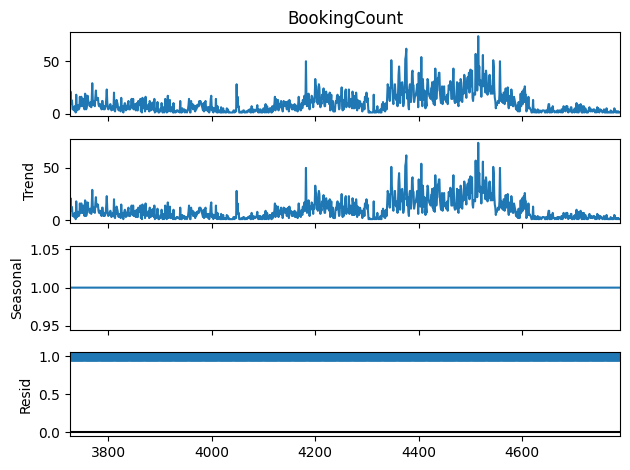

In [33]:
res = sm.tsa.seasonal_decompose(hotel_data['BookingCount'].interpolate(),
                                period=1,
                                model='multiplicative')
resplot = res.plot()

Here we can see the trend but absolute lack of seasonality.

In [34]:
res.resid[np.isfinite(res.resid) == False] = 0

In [35]:
res_resid = sm.tsa.seasonal_decompose(res.resid.interpolate(),
                                period=52,
                                model='additive')

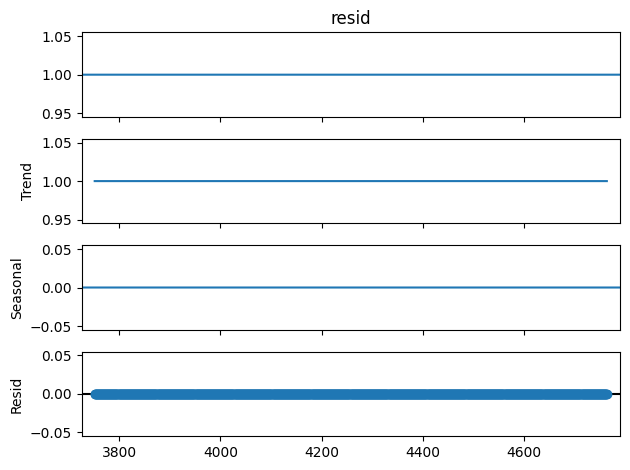

In [36]:
resplot = res_resid.plot()

## Anomaly detection.
An anomaly in a time series refers to a data point or sequence of data points that significantly deviates from the expected patterns or trends typically observed in the data. These anomalies can manifest in various ways, such as abrupt changes in values, an increase in NULL values, missing data segments, or other irregular patterns that deviate from normal fluctuations. As discussed in [Anomaly Detection in Time Series: A Comprehensive Evaluation](https://www.vldb.org/pvldb/vol15/p1779-wenig.pdf), such anomalies can indicate significant events or issues within the system being analyzed. In our specific context, an anomaly might suggest that during certain periods, the demand exceeded the hotel's operational capacity.
Numerous techniques for anomaly detection have been evaluated in the literature. During our research, we identified an effective algorithm that can be applied to the residual component of a seasonal-trend decomposition, utilizing the Isolation Forest method. This approach is both efficient and fast. We propose this algorithm for anomaly detection at each hotel level, as inspired by the work on [Unsupervised Anomaly Detection on Server Metrics](https://webthesis.biblio.polito.it/21240/1/tesi.pdf).

#### Anomaly detection with Isolation Forest
The steps of the algorithm are:
1. Normalization of the time series
2. Seasonal trend decomposition of the time series to extract the residual.
3. Applying ISOLATION FOREST to the residual
4. Remove points not considered anomalous by the Isolation Forest
5. Apply DBSCAN to the points outside the confidence region to obtain clusters of points close to each other
6. Points that do not belong to any cluster are the anomalies

[Isolation Forest](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8888179) algorithm directly seeks anomalous points based on the contamination parameter. First, the algorithm builds a forest of random decision trees. After training, it assigns an anomaly score to each data point. At this stage, we don't know whether a point is an inlier or outlier. The contamination parameter serves as a threshold, determining how many points are classified as outliers by converting these raw scores into inlier or outlier labels.

In [37]:
!pip install matplot statsmodels numpy

### 1. Normalization of time series
We will now proceed with analyzing the time series data from Hotel 008, as this dataset appears interesting. Specifically, the boxplot has revealed some outlier points exceeding the maximum threshold. At the conclusion of this analysis, we will write a function that can be applied to each hotel. We want to scale the data as to detect outliers we will use isolation forest, that require data scaling.

In [38]:
from sklearn.preprocessing import MinMaxScaler
# random forest requirement
# normalization scales each value of booking count to range 0.1
min_max_scaler = MinMaxScaler(feature_range=(0,1))
booking_count = hotel_data[['BookingCount']] 
booking_count_scaled = min_max_scaler.fit_transform(booking_count)
hotel_data['BookingCount_Scaled'] = booking_count_scaled
booking_hotel_scaled = hotel_data.drop(columns=['HotelId'])

### 2. Seasonal-Trend decomposition using LOESS

Time series data can have a well known set of pattern.
Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category.
- Trend: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.
-  A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency. 
- Cyclice cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. 

Statsmodels offers a seasonal decomposition tool that allows us to break down the different components of a time series, enabling a clear and visual understanding of how each component contributes to the overall behavior of the data. An additive model is applied when the trend appears linear, and the seasonal and trend components remain relatively constant over time (e.g., each year, we add 1000 new booking). In contrast, a multiplicative model is more suitable when the data shows a non-linear growth or decline (e.g., doubling the number of bookings). Our interest in findining anomalies is to look in the residual, the difference of the trend effect with the seasonality component. In that subset of data might happen that there are errors due to series peak or seasonal bookings.

In [39]:
booking_hotel_scaled.head()

Arrival  BookingCount  BookingCount_Scaled
3726 2020-01-01            13             0.164384
3727 2020-01-02            21             0.273973
3728 2020-01-03             9             0.109589
3729 2020-01-04            13             0.164384
3730 2020-01-05            11             0.136986

<Axes: >

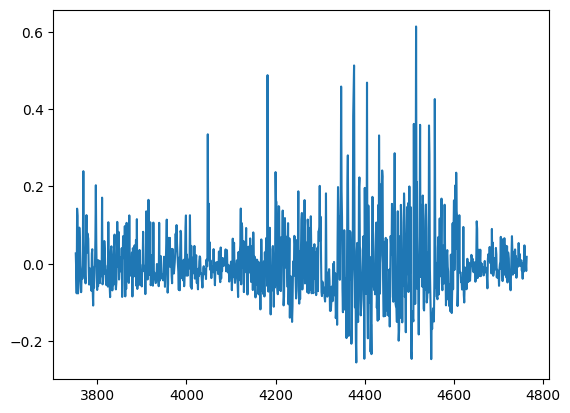

In [40]:
season_decomposed = sm.tsa.seasonal_decompose(booking_hotel_scaled['BookingCount_Scaled'].interpolate(),period=52)
residual = season_decomposed.resid
residual.plot()

### 3. Apply Isolation Forest on Residual


In [41]:
residual.head()

3726   NaN
3727   NaN
3728   NaN
3729   NaN
3730   NaN
Name: resid, dtype: float64

In [42]:
data = residual.fillna(residual.mean())
data.count()

1064

In [43]:
data.head()

3726    0.000299
3727    0.000299
3728    0.000299
3729    0.000299
3730    0.000299
Name: resid, dtype: float64

In [44]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest()  
values = clf.fit_predict(data.values.reshape(-1, 1))
booking_hotel_scaled['anomaly_score'] = values
booking_hotel_scaled['is_anomaly'] = booking_hotel_scaled['anomaly_score'] == -1

In [45]:
booking_hotel_scaled.head(50)

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly
3726 2020-01-01            13             0.164384              1       False
3727 2020-01-02            21             0.273973              1       False
3728 2020-01-03             9             0.109589              1       False
3729 2020-01-04            13             0.164384              1       False
3730 2020-01-05            11             0.136986              1       False
3731 2020-01-06             4             0.041096              1       False
3732 2020-01-07             4             0.041096              1       False
3733 2020-01-08             6             0.068493              1       False
3734 2020-01-09             3             0.027397              1       False
3735 2020-01-10             7             0.082192              1       False
3736 2020-01-11             4             0.041096              1       False
3737 2020-01-12             1             0.000000              1       False
3738 2020-01-13            18             0.232877              1       False
3739 2020-01-14             6             0.068493              1       False
3740 2020-01-15             3             0.027397              1       False
3741 2020-01-16             8             0.095890              1       False
3742 2020-01-17             5             0.054795              1       False
3743 2020-01-18             4             0.041096              1       False
3744 2020-01-19             5             0.054795              1       False
3745 2020-01-20            16             0.205479              1       False
3746 2020-01-21             7             0.082192              1       False
3747 2020-01-22            14             0.178082              1       False
3748 2020-01-23            16             0.205479              1       False
3749 2020-01-24             7             0.082192              1       False
3750 2020-01-25             9             0.109589              1       False
3751 2020-01-26             7             0.082192              1       False
3752 2020-01-27            14             0.178082              1       False
3753 2020-01-28             8             0.095890              1       False
3754 2020-01-29             4             0.041096              1       False
3755 2020-01-30            19             0.246575             -1        True
3756 2020-01-31            18             0.232877             -1        True
3757 2020-02-01             4             0.041096              1       False
3758 2020-02-02             5             0.054795              1       False
3759 2020-02-03             8             0.095890              1       False
3760 2020-02-04            17             0.219178              1       False
3761 2020-02-05            13             0.164384              1       False
3762 2020-02-06            10             0.123288              1       False
3763 2020-02-07            10             0.123288              1       False
3764 2020-02-09             7             0.082192              1       False
3765 2020-02-10             9             0.109589              1       False
3766 2020-02-11            11             0.136986              1       False
3767 2020-02-12             6             0.068493              1       False
3768 2020-02-13            15             0.191781              1       False
3769 2020-02-14            29             0.383562             -1        True
3770 2020-02-15            13             0.164384              1       False
3771 2020-02-16             8             0.095890              1       False
3772 2020-02-17            12             0.150685              1       False
3773 2020-02-18             9             0.109589              1       False
3774 2020-02-19             7             0.082192              1       False
3775 2020-02-20            16             0.205479              1       False

### 4. Remove the points that are not consided anomalies by IsolationForest.

In [46]:
hotel_anomalies = booking_hotel_scaled[booking_hotel_scaled['anomaly_score']==-1]
hotel_anomalies.head(46)

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly
3755 2020-01-30            19             0.246575             -1        True
3756 2020-01-31            18             0.232877             -1        True
3769 2020-02-14            29             0.383562             -1        True
3776 2020-02-21            22             0.287671             -1        True
3791 2020-03-07             4             0.041096             -1        True
3797 2020-03-13            23             0.301370             -1        True
3811 2020-03-27            20             0.260274             -1        True
3825 2020-04-10            15             0.191781             -1        True
3845 2020-04-30            14             0.178082             -1        True
3862 2020-05-17            14             0.178082             -1        True
3866 2020-05-21            15             0.191781             -1        True
3872 2020-05-27            16             0.205479             -1        True
3889 2020-06-13            14             0.178082             -1        True
3910 2020-07-04            14             0.178082             -1        True
3915 2020-07-10            17             0.219178             -1        True
3919 2020-07-14            13             0.164384             -1        True
3926 2020-07-22            10             0.123288             -1        True
3939 2020-08-06            12             0.150685             -1        True
3956 2020-08-29            14             0.178082             -1        True
3978 2020-09-23            12             0.150685             -1        True
3999 2020-10-14            17             0.219178             -1        True
4008 2020-10-24            14             0.178082             -1        True
4048 2021-04-05            28             0.369863             -1        True
4050 2021-04-07            16             0.205479             -1        True
4122 2021-07-03            16             0.205479             -1        True
4124 2021-07-05            14             0.178082             -1        True
4125 2021-07-06            12             0.150685             -1        True
4166 2021-08-17             2             0.013699             -1        True
4182 2021-09-04            50             0.671233             -1        True
4189 2021-09-11             4             0.041096             -1        True
4196 2021-09-18             6             0.068493             -1        True
4200 2021-09-22            33             0.438356             -1        True
4201 2021-09-23            26             0.342466             -1        True
4202 2021-09-24            26             0.342466             -1        True
4207 2021-09-29            28             0.369863             -1        True
4208 2021-09-30            25             0.328767             -1        True
4216 2021-10-08            24             0.315068             -1        True
4218 2021-10-10             7             0.082192             -1        True
4221 2021-10-13            21             0.273973             -1        True
4228 2021-10-20            20             0.260274             -1        True
4229 2021-10-21             3             0.027397             -1        True
4232 2021-10-24             4             0.041096             -1        True
4235 2021-10-27             2             0.013699             -1        True
4236 2021-10-28             4             0.041096             -1        True
4237 2021-10-29             2             0.013699             -1        True
4238 2021-10-30             2             0.013699             -1        True

In [47]:
print(f'Anomalies count {hotel_anomalies.shape[0]} over {booking_hotel_scaled.shape[0]}')

Anomalies count 186 over 1064


### 5.Apply DBScan on the Isolation Forest Anomalies. 
The points that don't belong to any cluster are anomalies and we can pass from 46 to much less. The eps is placed to 0.1. [DBScan](https://dl.acm.org/doi/10.1145/3068335) has num points and eps as hyperparameter. A better way to select the value of eps is described in [Fast Density-Based Clustering with R](https://www.jstatsoft.org/article/view/v091i01). The paper proposes using KNN to estimate the distance from each point to its nearest neighbor within the same partition, followed by sorting and selecting the minimum. However, we opted to use an empirical value derived from direct data exploration.

In [48]:
hotel_anomalies['Arrival_float'] = hotel_anomalies['Arrival'].apply(lambda x: x.timestamp())
hotel_anomalies.head()

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly  \
3755 2020-01-30            19             0.246575             -1        True   
3756 2020-01-31            18             0.232877             -1        True   
3769 2020-02-14            29             0.383562             -1        True   
3776 2020-02-21            22             0.287671             -1        True   
3791 2020-03-07             4             0.041096             -1        True   

      Arrival_float  
3755   1.580342e+09  
3756   1.580429e+09  
3769   1.581638e+09  
3776   1.582243e+09  
3791   1.583539e+09

In [49]:
from sklearn.cluster import DBSCAN
X = hotel_anomalies[['BookingCount_Scaled']].values
dbscan = DBSCAN(eps=0.1, min_samples=10)
dbscan.fit(X)
hotel_anomalies['Cluster'] = dbscan.labels_
outliers = hotel_anomalies[hotel_anomalies['Cluster'] == -1]
outliers.count()

Arrival                1
BookingCount           1
BookingCount_Scaled    1
anomaly_score          1
is_anomaly             1
Arrival_float          1
Cluster                1
dtype: int64

In [50]:
outliers.head()

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly  \
4515 2022-09-29            74                  1.0             -1        True   

      Arrival_float  Cluster  
4515   1.664410e+09       -1

In Italy August, December and beginning of January are typically vacation time so it is normal having anomalies.

In [51]:
from datetime import datetime
collect_idx_to_remove = []
for idx,value in outliers.iterrows():
    date = value[0].to_pydatetime()
    # we exclude december, august, and january till 6
    if ((date.month == 12) or (date.month == 8) or (date.month ==1 and date.day < 7)):
        collect_idx_to_remove.append(idx)
outliers_cleaned = outliers.drop(index=collect_idx_to_remove)
outliers_cleaned.head()

Arrival  BookingCount  BookingCount_Scaled  anomaly_score  is_anomaly  \
4515 2022-09-29            74                  1.0             -1        True   

      Arrival_float  Cluster  
4515   1.664410e+09       -1

Now we can act in two ways in case of forecasting:
- remove the outliers in case of error since
- evalutating when happens and if they are legit (high season, events, christmas) keep them.

We can remove safely the outliners except for the week of Christmas and First week of the year We can establish, having seen the data distribution that **peak are not anomalies** in:
1. Christmas period
2. First week of the year
3. August

Now we need to generalize for each hotel. We're gonna define a function **clean_time_series** in Python that include all the code we've see to clean up from outliers and a **restrict_outliers** that take in account the vacation times.

In [52]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from datetime import datetime
def restrict_outliers(outliers: pd.DataFrame) -> pd.DataFrame:
    collect_idx_to_remove = []
    for idx,value in outliers.iterrows():
        date = value[1].to_pydatetime()
        # we exclude december, august, and january till 6
        if ((date.month == 12) or (date.month == 8) or (date.month ==1 and date.day < 7)):
            collect_idx_to_remove.append(idx)
    outliers.drop(index=collect_idx_to_remove)
    return outliers

# we can apply this function to each hotel to clean data
def clean_time_series(hd: pd.DataFrame) -> pd.DataFrame:
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    booking_count = hd[['BookingCount']] 
    booking_count_scaled = min_max_scaler.fit_transform(booking_count)
    hd['BookingCount_Scaled'] = booking_count_scaled
    season_decomposed = sm.tsa.seasonal_decompose(hd['BookingCount_Scaled'].interpolate(),period=52)
    residual = season_decomposed.resid
    data = residual.fillna(residual.mean())
    clf = IsolationForest()  
    values = clf.fit_predict(data.values.reshape(-1, 1))
    hd['anomaly_score'] = values
    hotel_anomalies = hd[hd['anomaly_score']==-1]
    X = hotel_anomalies[['BookingCount_Scaled']].values
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    dbscan.fit(X)
    hotel_anomalies['Cluster'] = dbscan.labels_
    outliers = restrict_outliers(hotel_anomalies[hotel_anomalies['Cluster'] == -1])
    hd = hd.drop(outliers.index.to_list())
    return hd


## Model Selection for Demand Score
Now we clean our scaled data to validate which model is better and then we start with model selection. We have to investigate between Facebook [Prophet](https://peerj.com/preprints/3190.pdf) and SARIMAX.


In [53]:
hotel_evaluation_ds = clean_time_series(hotel_data)

In [54]:
print(f'Series size after cleaning {hotel_evaluation_ds.shape[0]} and before {hotel_data.shape[0]}')

Series size after cleaning 1063 and before 1064


In [55]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")


demand_ds = hotel_evaluation_ds[['Arrival','BookingCount']]
demand_ds['Arrival'] = pd.to_datetime(hotel_evaluation_ds['Arrival'])
demand_ds.head()

Arrival  BookingCount
3726 2020-01-01            13
3727 2020-01-02            21
3728 2020-01-03             9
3729 2020-01-04            13
3730 2020-01-05            11

### Descriptive Analytics on cleaned dataset
A lot of transformation has been effected the original data. So before passing to see Prophet and crafting model a bit of descriptive analytics is needed 
on the resulting model. So we'd like to see:
- The behaviour in the first 12 months: trend and standard deviation
- ACF plots and PACF plots (https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb) that are useful to intepret a time series.

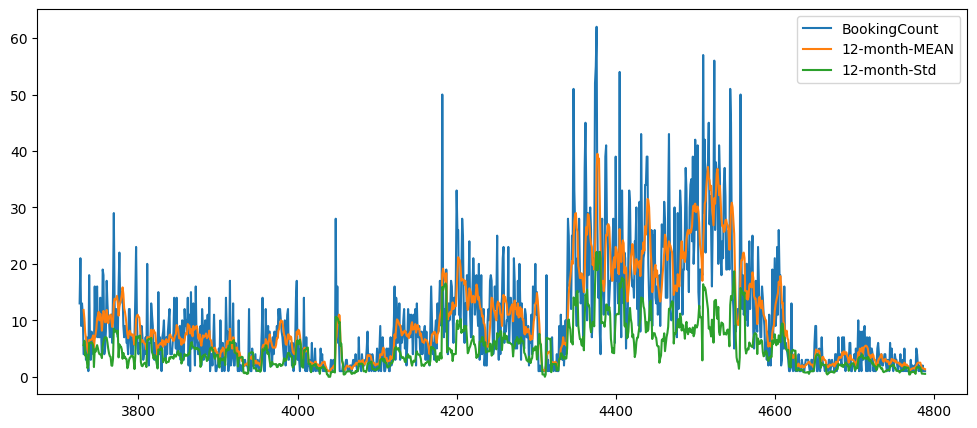

In [56]:
df = demand_ds.copy()
df['12-month-MEAN'] = df['BookingCount'].rolling(window=6).mean()
df['12-month-Std'] = df['BookingCount'].rolling(window=6).std()
df[['BookingCount','12-month-MEAN','12-month-Std']].plot(figsize=(12,5));


Statsmodels offers a seasonal decomposition tool that allows us to break down the different components of a time series, enabling a clear and visual understanding of how each component contributes to the overall behavior of the data.

An additive model is applied when the trend appears linear, and the seasonal and trend components remain relatively constant over time (e.g., each year, we add 10,000 passengers). In contrast, a multiplicative model is more suitable when the data shows a non-linear growth or decline (e.g., doubling the number of passengers each year). In our case as stated previously we use a multiplicative model.

In [57]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

In [58]:
demand_ds.reset_index()

index    Arrival  BookingCount
0      3726 2020-01-01            13
1      3727 2020-01-02            21
2      3728 2020-01-03             9
3      3729 2020-01-04            13
4      3730 2020-01-05            11
...     ...        ...           ...
1058   4785 2023-10-06             1
1059   4786 2023-10-08             2
1060   4787 2023-11-05             1
1061   4788 2023-11-08             1
1062   4789 2023-11-24             1

[1063 rows x 3 columns]

In [59]:
demand_ds.head()

Arrival  BookingCount
3726 2020-01-01            13
3727 2020-01-02            21
3728 2020-01-03             9
3729 2020-01-04            13
3730 2020-01-05            11

We have already seen the seasonal decomposition that in our case is multiplicative. We want to see the seasonality exploring the monthly plot and the existence of null values. We also need to check for stationarity since it is a requirement for SARIMAX.


#### Check for null and invalid values.

In [60]:
print(demand_ds[['BookingCount', 'Arrival']].isnull().sum())

BookingCount    0
Arrival         0
dtype: int64


In [61]:
#### Check for stationarity.

In [62]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/
    
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


In [63]:
check_stationarity(demand_ds['BookingCount'])

ADF Statistic: -2.287893
p-value: 0.175903
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary


The series is no stationary so any attempt to use classical series analysis like SARIMAX will fail.We will remove the non-stationarity before further analysis.

# Non-Stationarity Removal.


In [64]:
df_log=pd.DataFrame(np.log(demand_ds['BookingCount']),index=demand_ds.index)
demand_ds = demand_ds.dropna()
demand_ds_log= demand_ds.copy()
demand_ds_log['BookingCount'] = df_log
demand_ds_log.head()

Arrival  BookingCount
3726 2020-01-01      2.564949
3727 2020-01-02      3.044522
3728 2020-01-03      2.197225
3729 2020-01-04      2.564949
3730 2020-01-05      2.397895

In [65]:
adftest=adfuller(demand_ds_log['BookingCount'])
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])


ADF Statistic: -2.177813
ADF p-value: 0.214396


In [66]:
demand_ds['Booking']=demand_ds['BookingCount']-demand_ds['BookingCount'].shift(1)
adftest_ret=adfuller(demand_ds['Booking'].dropna())
print('Returns ADF Statistic: %f' % adftest_ret[0])
print('Returns ADF p-value: %f' % adftest_ret[1])


Returns ADF Statistic: -11.133379
Returns ADF p-value: 0.000000


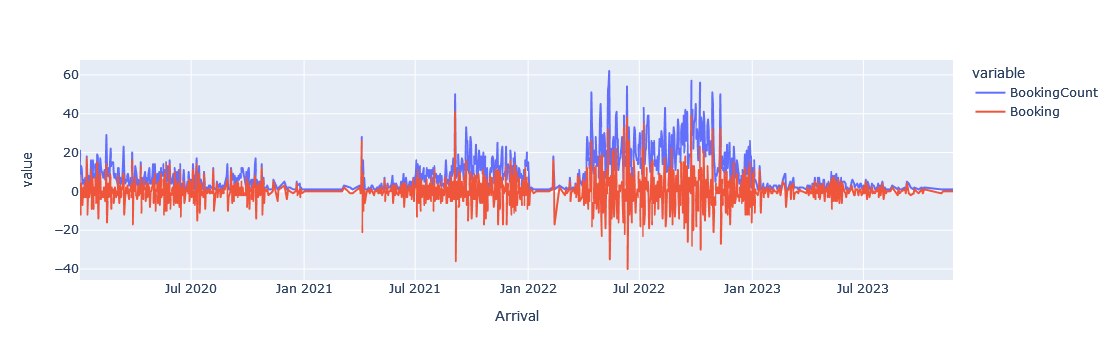

In [67]:
demand_ds = demand_ds.dropna()
fig = px.line(demand_ds, x='Arrival', y=['BookingCount','Booking'])
fig.show()


In [68]:
adftest_ret=adfuller(demand_ds['Booking'].dropna())
print('Returns ADF Statistic: %f' % adftest_ret[0])
print('Returns ADF p-value: %f' % adftest_ret[1])

demand_ds.dropna()
demand_ds.drop(labels=['BookingCount'],axis=1,inplace=True)
demand_ds = demand_ds.rename({'Booking':'BookingCount'},axis=1)
demand_ds.head()

Returns ADF Statistic: -11.133379
Returns ADF p-value: 0.000000


Arrival  BookingCount
3727 2020-01-02           8.0
3728 2020-01-03         -12.0
3729 2020-01-04           4.0
3730 2020-01-05          -2.0
3731 2020-01-06          -7.0

In [69]:
check_stationarity(demand_ds['BookingCount'])

ADF Statistic: -11.133379
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Stationary


#### Monthly Plot, ACF, PACF

Now we plot the lags and the autocorrelation. A correct defintion comes from investopedia (represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.Autocorrelation measures the relationship between a variable's current value and its past values. It measures utocorrelation measures the relationship of a variable with lagged values of itself.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

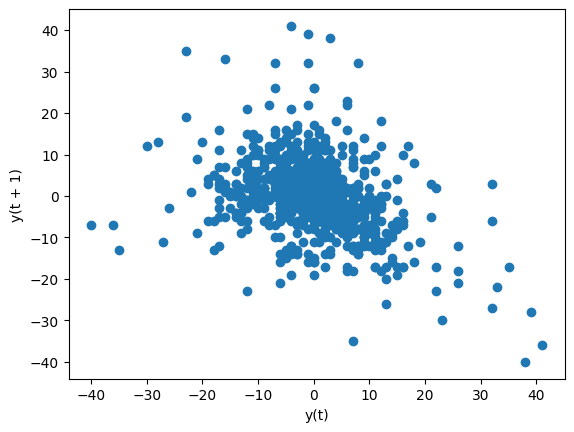

In [70]:
lag_plot(demand_ds['BookingCount'])

The data scatter we see a trend but not really a strong autocorrelation. Let's investigate more with ACF and PACF.

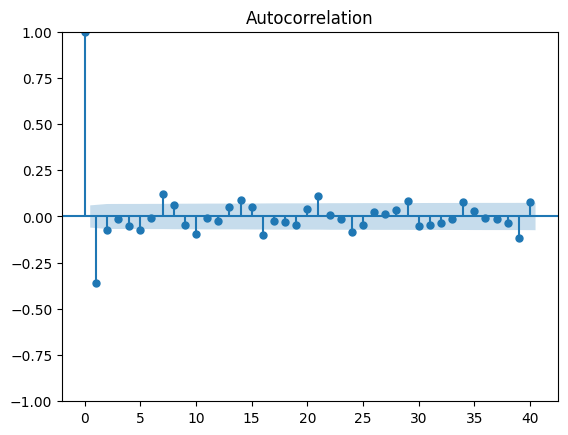

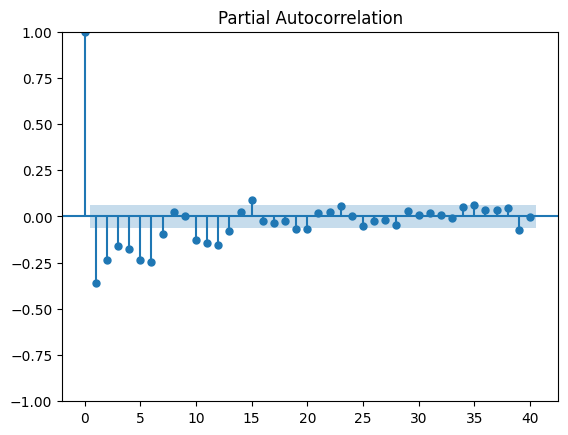

In [71]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(demand_ds['BookingCount'], lags=40)
plot_pacf(demand_ds['BookingCount'], lags=40)
plt.show()


Autocorrelation measures the linear relationship between lagged values. In the Autocorrelation plot we have several autocorrelation coefficient plotted together.
- When data have a trend, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.
- When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.
- When data are both trended and seasonal, you see a combination of these effects.

The value of the autocorrelation are in geneal very high indicating corrrelation at each lag, increases and decreaseas periodically without following a precise trend. We expect for a non-stationary series, this close to 1 behavior is typically of non

A time-series is [stationary](https://www.timescale.com/learn/stationary-time-series-analysis) statistical properities don't change over the time. This implies that the distribution's shape, spread, and central tendency remain consistent over time, regardless of when the observations were made.

Due to the possibility of a non-stactionary series we need to check if it is not stationary and using a traditional difference to transform the series from
non stationary making the analysis difficult since its charateristics (variance, mean, etc) change with time. Let's do the test now.


## Model building with Prophet.

[Prophet](https://facebook.github.io/prophet/) imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column). So, we must rename the columns in our dataframe.


In [72]:
prophet_ds = demand_ds.rename(columns={'Arrival': 'ds','BookingCount': 'y'})
prophet_ds.reset_index()
prophet_ds.head()

ds     y
3727 2020-01-02   8.0
3728 2020-01-03 -12.0
3729 2020-01-04   4.0
3730 2020-01-05  -2.0
3731 2020-01-06  -7.0

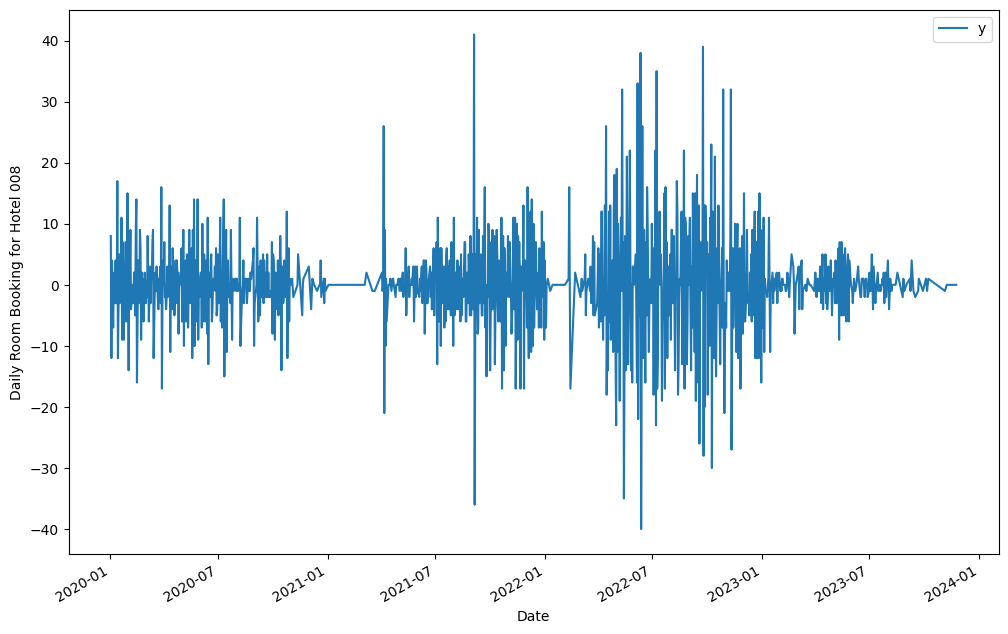

In [73]:
ax = prophet_ds.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Daily Room Booking for Hotel 008')
ax.set_xlabel('Date')
plt.show()

In [74]:
prophet_model = Prophet(interval_width=0.90)

In [75]:
model = prophet_model.fit(prophet_ds)

19:51:11 - cmdstanpy - INFO - Chain [1] start processing
19:51:11 - cmdstanpy - INFO - Chain [1] done processing


Now we tell to Prophet to generate future dataset. Later we use the same method to aggregate data to compute demand score. The make_future_dataframe starts from the beginning of the dataset so we have to specify the exact number of weeks in period.

In [76]:
prophet_future_ds = model.make_future_dataframe(periods=60, freq='D')
prophet_future_ds.tail()

ds
1117 2024-01-19
1118 2024-01-20
1119 2024-01-21
1120 2024-01-22
1121 2024-01-23

In [77]:
prophet_demand_score_forecast = model.predict(prophet_future_ds)
prophet_demand_score_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds      yhat  yhat_lower  yhat_upper
0 2020-01-02  0.985855  -11.657439   13.129610
1 2020-01-03  0.940509  -11.969377   13.930451
2 2020-01-04 -2.582907  -14.548592    9.456285
3 2020-01-05 -3.982036  -16.093827    9.151776
4 2020-01-06  0.793974  -11.687693   13.427993

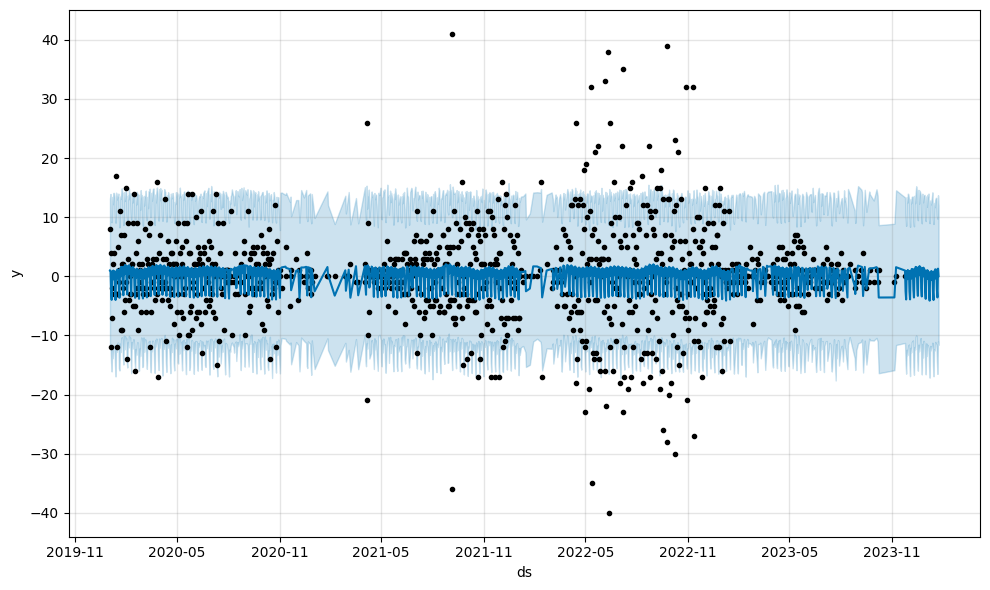

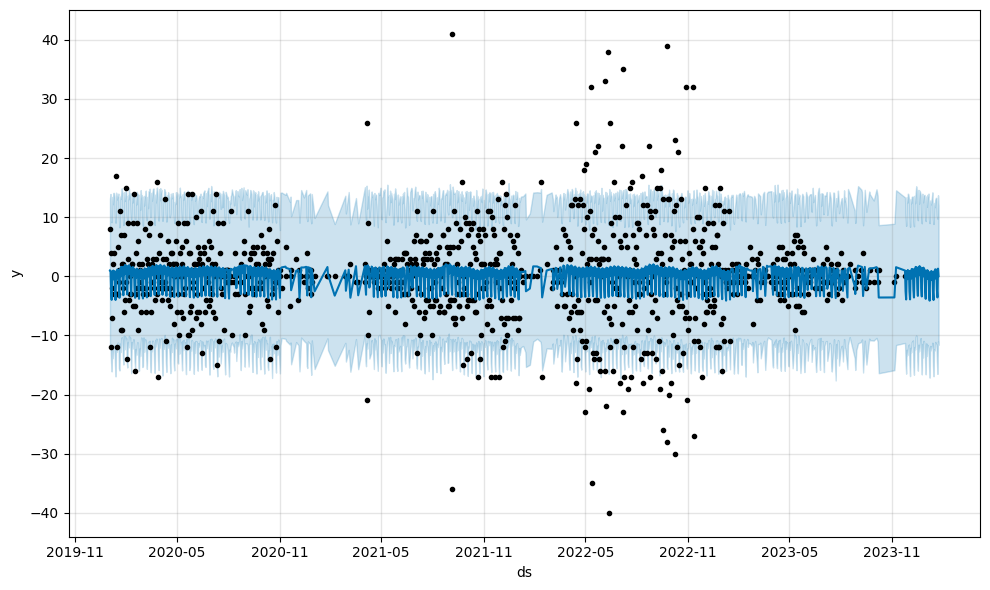

In [78]:
model.plot(prophet_demand_score_forecast, uncertainty=True)

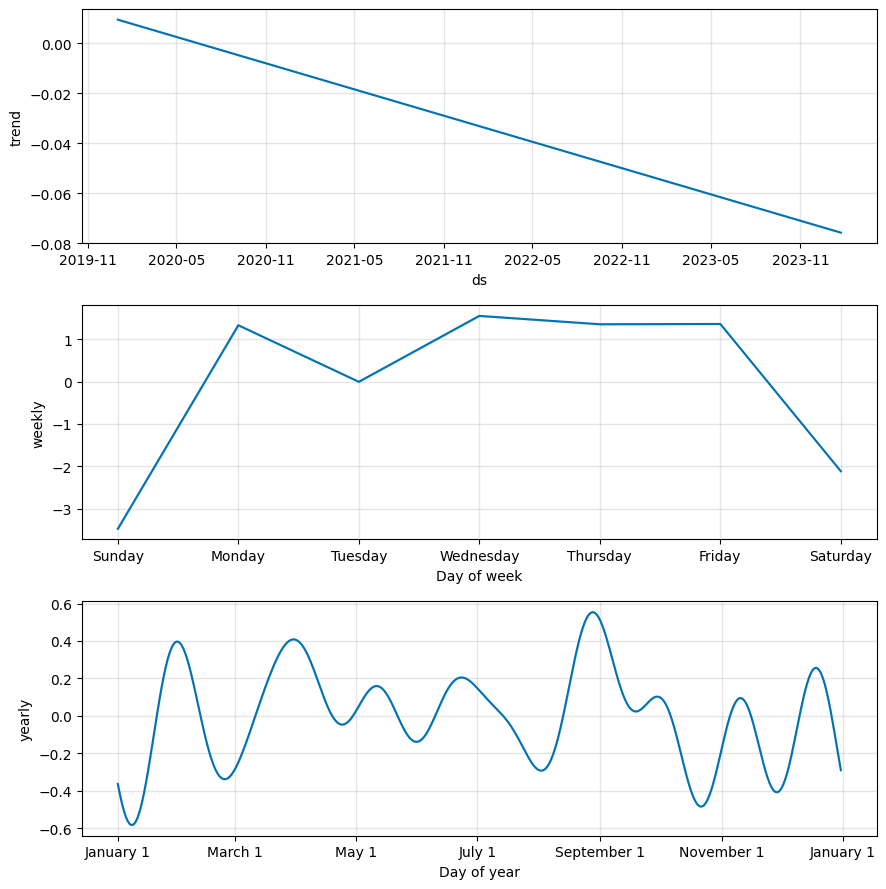

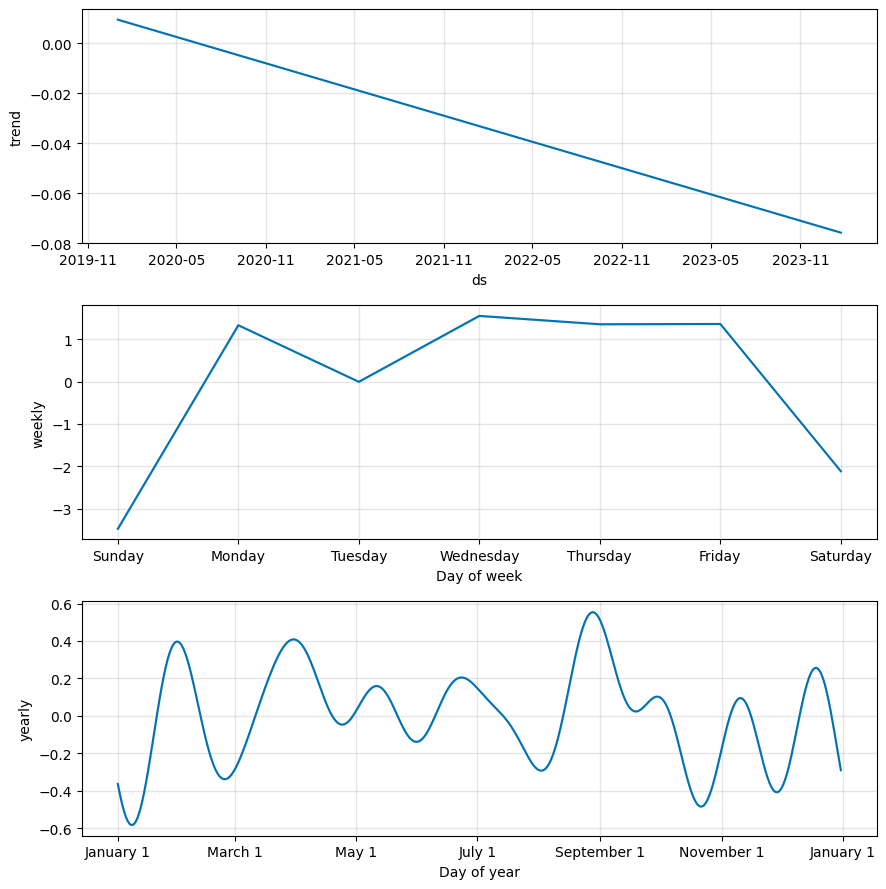

In [79]:
prophet_model.plot_components(prophet_demand_score_forecast)



In [80]:
# prophet has cross validaton
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(prophet_model, initial='365 days', period='365 days', horizon='365 days')
df_p = performance_metrics(df_cv)
df_p.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/2 [00:00<?, ?it/s]

19:51:12 - cmdstanpy - INFO - Chain [1] start processing
19:51:12 - cmdstanpy - INFO - Chain [1] done processing
19:51:12 - cmdstanpy - INFO - Chain [1] start processing
19:51:12 - cmdstanpy - INFO - Chain [1] done processing


horizon        mse      rmse       mae    mdape     smape  coverage
0 26 days  52.913467  7.274164  5.716495  0.93321  1.492365  0.846154
1 27 days  56.231569  7.498771  5.916091  0.93321  1.486925  0.826923
2 28 days  50.503362  7.106572  5.633874  0.93321  1.479022  0.865385
3 29 days  47.306883  6.878000  5.521399  0.93321  1.493995  0.884615
4 30 days  48.528351  6.966229  5.593203  0.93321  1.499338  0.884615

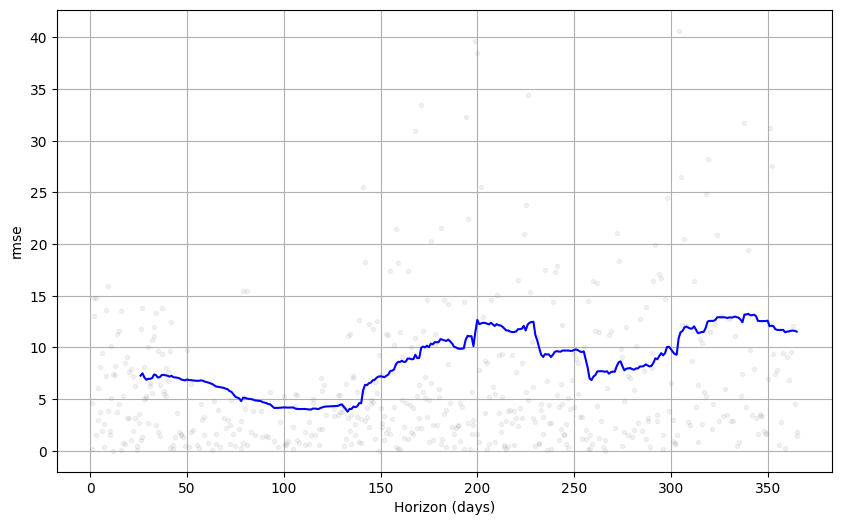

In [81]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


In [82]:
!pip install optuna

# Prophet Hyperparameter Tuning
Accordingly to prophet documentation, if we want to tune parameters, the first ones to be tunned should be:
1. **changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend and, in particular, how much the trend changes at the trend changepoints.
2. **seasonality_prior_scale**: This parameter controls the flexibility of the seasonality.
3. **holidays**: This controls flexibility to fit holiday effects.
4. **seasonality_mode**: Options are ['additive', 'multiplicative'].

We will use [Optuna](https://optuna.org/) for hyperparamter tuning. The main reason are the speed of execution and flexibility: it adapts to any machine learning model, it is written in Rust with python binding (so it is fast) and uses a different approach from GridSearch. Instead of exploring randomly the parameter space and trying to find the best uses an heuristic to prune the solutions and converge faster. It works in several step:
- define an objective function
- create a number of trials
- create study that trigger the trials
- find the best parameters as result ot that study.

First from [Prophet Hyperparamter documentation](https://facebook.github.io/prophet/docs/diagnostics.html) we see which are parameter interested to us.

In [83]:
import optuna


We insert all italian holidays so the time series model can take in account.

In [84]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2020-01-01', '2021-01-01','2022-01-01','2023-01-01'])})  
befana = pd.DataFrame({'holiday': 'Befana', 'ds' : pd.to_datetime(['2020-01-06', '2021-01-06','2022-01-06','2023-01-06'])})
# Day in which italy has been freed by the nazis! Hasta la victoria siempre!
resistence_day = pd.DataFrame({'holiday': 'Resistence Day', 'ds' : pd.to_datetime(['2020-04-25', '2021-04-25','2022-04-25','2023-04-25'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2020-05-01', '2021-05-01', '2022-05-01','2023-05-01'])})
republic_day = pd.DataFrame({'holiday': 'Republic Day', 'ds' : pd.to_datetime(['2020-06-02', '2021-06-02', '2022-06-02','2023-06-02'])})
midsummer = pd.DataFrame({'holiday': "Midsummer Day", 'ds' : pd.to_datetime(['2020-08-15', '2021-08-15', '2022-08-15','2023-08-15'])})
maryday = pd.DataFrame({'holiday': 'St.Nicholas', 'ds' : pd.to_datetime(['2020-12-08', '2021-12-08','2022-12-09','2023-12-08'])})
christmas = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2020-12-25', '2021-12-25','2022-12-25','2023-12-25'])})
ststevenday=pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2020-12-26', '2021-12-26','2022-12-26','2023-12-26'])})
italian_public_holidays = pd.concat([ny, befana, resistence_day, lab, republic_day, midsummer, maryday, christmas,ststevenday])
italian_public_holidays.head()

holiday         ds
0  New Year's Day 2020-01-01
1  New Year's Day 2021-01-01
2  New Year's Day 2022-01-01
3  New Year's Day 2023-01-01
0          Befana 2020-01-06

Now we have to define the objective function using above parameters variation. Optuna has the concept of objective function to satisfy in order to perform early stopping.

In [85]:
def objective(trial):
    params = {
        'holidays': italian_public_holidays,  # Ensure this is a DataFrame with 'ds' and 'holiday' columns
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.2, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
    }
    
    m = Prophet(**params)
    m.add_seasonality(name='weekly', period=7, fourier_order=trial.suggest_int('weekly_seasonality', 5, 10))
    m.add_seasonality(name='yearly', period=365.25, fourier_order=trial.suggest_int('yearly_seasonality', 1, 20))
    
    m.fit(prophet_ds)

    number_initial_days = (prophet_ds['ds'].max() - prophet_ds['ds'].min()).days - 365
    if number_initial_days < 0:
        raise ValueError("Insufficient data for cross-validation")
    
    df_cv = cross_validation(m, 
                             initial=f'{number_initial_days} days', 
                             period='365 days', 
                             horizon='365 days',
                             parallel="processes")

    df_p = performance_metrics(df_cv, rolling_window=1)
    if df_p.empty:
        raise ValueError("Cross-validation returned an empty performance metrics dataframe")

    return df_p['rmse'].values[0]


In [86]:
study = optuna.create_study(study_name="demandscore_prophet",direction='minimize')
# in production we can try up to 100 but in this case we limit to 10
study.optimize(objective, n_trials=10)

[I 2024-10-26 19:51:16,447] A new study created in memory with name: demandscore_prophet
19:51:16 - cmdstanpy - INFO - Chain [1] start processing
19:51:16 - cmdstanpy - INFO - Chain [1] done processing
19:51:17 - cmdstanpy - INFO - Chain [1] start processing
19:51:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-26 19:51:17,498] Trial 0 finished with value: 6.50568387829911 and parameters: {'changepoint_prior_scale': 1.1055908265610217, 'changepoint_range': 0.6294709450882059, 'seasonality_prior_scale': 5.673998464546132, 'holidays_prior_scale': 5.558149324624667, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': 6, 'yearly_seasonality': 17}. Best is trial 0 with value: 6.50568387829911.
19:51:17 - cmdstanpy - INFO - Chain [1] start processing
19:51:17 - cmdstanpy - INFO - Chain [1] done processing
19:51:18 - cmdstanpy - INFO - Chain [1] start processing
19:51:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-10-26 19:51:18,730] Trial 1 finished with value

In [87]:
study.best_params

{'changepoint_prior_scale': 1.7926992956337762,
 'changepoint_range': 0.7762893115721547,
 'seasonality_prior_scale': 2.3920226954611885,
 'holidays_prior_scale': 9.145589948601097,
 'seasonality_mode': 'multiplicative',
 'weekly_seasonality': 8,
 'yearly_seasonality': 10}

## Prophet Cross Validation

In [88]:
prophet_model = Prophet(**study.best_params)
prophet_model.fit(prophet_ds)
number_initial_days = (prophet_ds['ds'].max() - prophet_ds['ds'].min()).days - 30
df_cv = cross_validation(prophet_model, initial=f'{number_initial_days} days', period='10 days', horizon='10 days',parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

19:51:24 - cmdstanpy - INFO - Chain [1] start processing
19:51:24 - cmdstanpy - INFO - Chain [1] done processing
19:51:24 - cmdstanpy - INFO - Chain [1] start processing
19:51:24 - cmdstanpy - INFO - Chain [1] start processing
19:51:25 - cmdstanpy - INFO - Chain [1] done processing
19:51:25 - cmdstanpy - INFO - Chain [1] done processing


horizon        mse      rmse       mae  mdape  smape  coverage
0 10 days  10.643379  3.262419  2.792244    inf    2.0       1.0

The Root Mean Square Error is acceptable, it is kind of 1 room every 10 days. It decreases when icrease the horizon.

In [89]:
number_initial_days = (prophet_ds['ds'].max() - prophet_ds['ds'].min()).days - 30
df_cv = cross_validation(prophet_model, initial=f'{number_initial_days} days', period='10 days', horizon='10 days',parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

19:51:26 - cmdstanpy - INFO - Chain [1] start processing
19:51:26 - cmdstanpy - INFO - Chain [1] start processing
19:51:26 - cmdstanpy - INFO - Chain [1] done processing
19:51:26 - cmdstanpy - INFO - Chain [1] done processing


horizon        mse      rmse       mae  mdape  smape  coverage
0 10 days  10.643379  3.262419  2.792244    inf    2.0       1.0

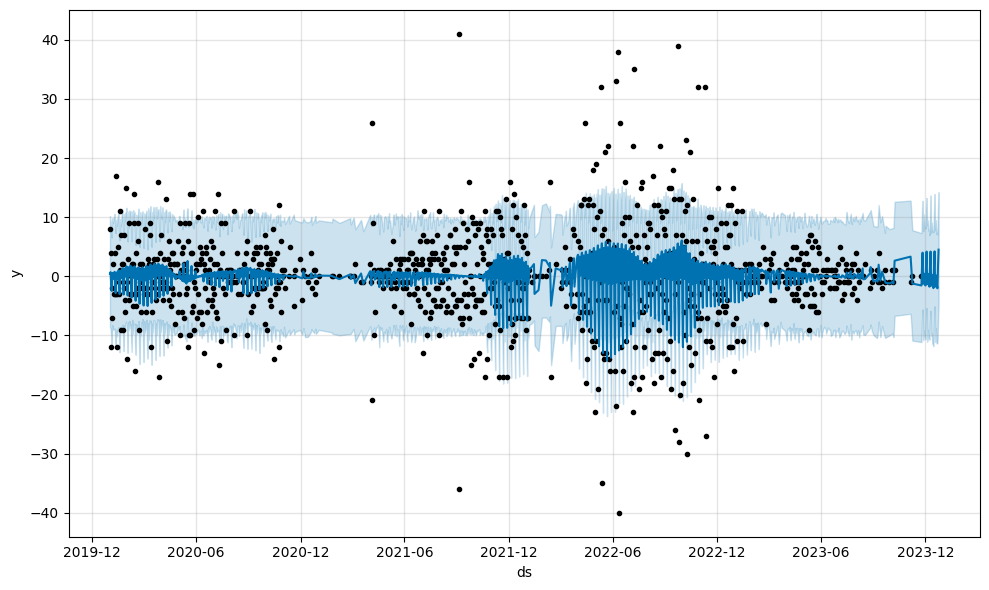

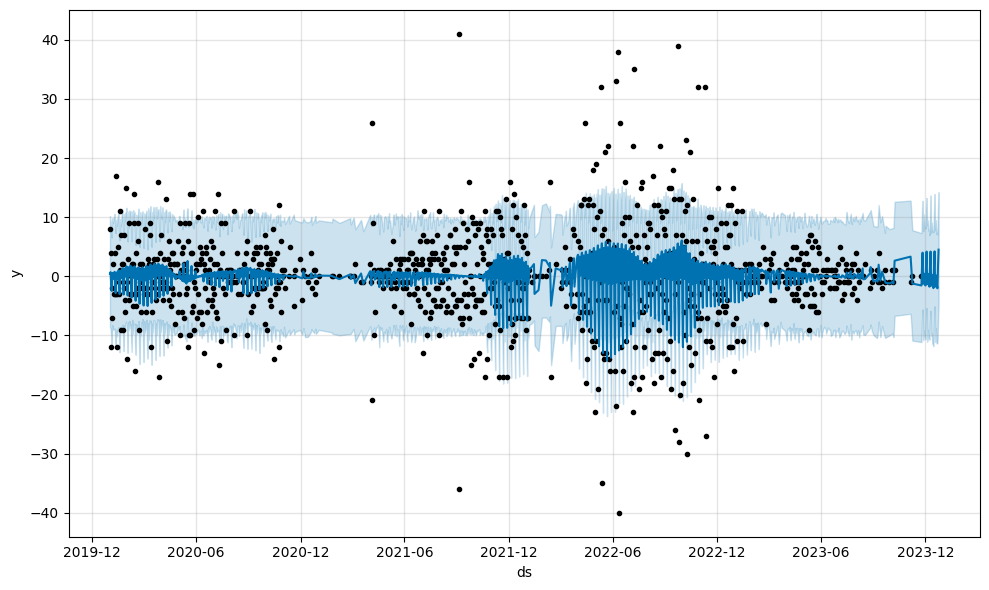

In [90]:
future_ds = model.make_future_dataframe(periods=30, freq='D')
forecast = prophet_model.predict(future_ds)
model.plot(forecast, uncertainty=True)

We are not fully satisfied at a given point the prediction become negatives in the tail. But we can use the forcasting 
for give an indication of the trend of the demand and with this trend compute the score.


In [91]:
future_ds.tail()

ds
1087 2023-12-20
1088 2023-12-21
1089 2023-12-22
1090 2023-12-23
1091 2023-12-24

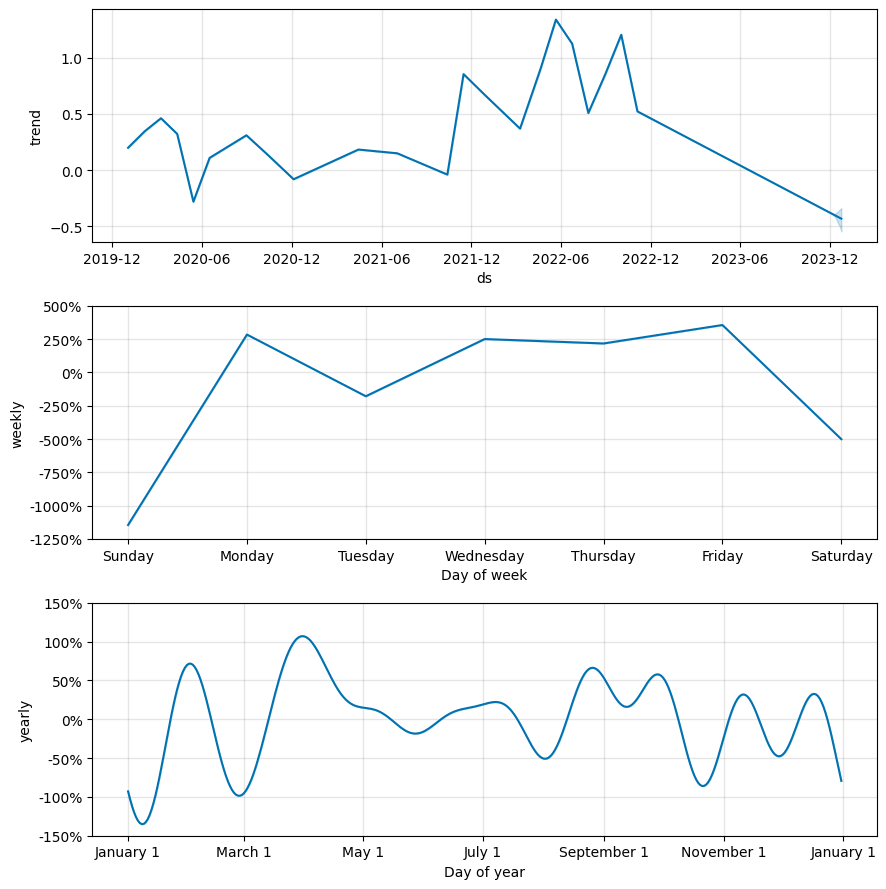

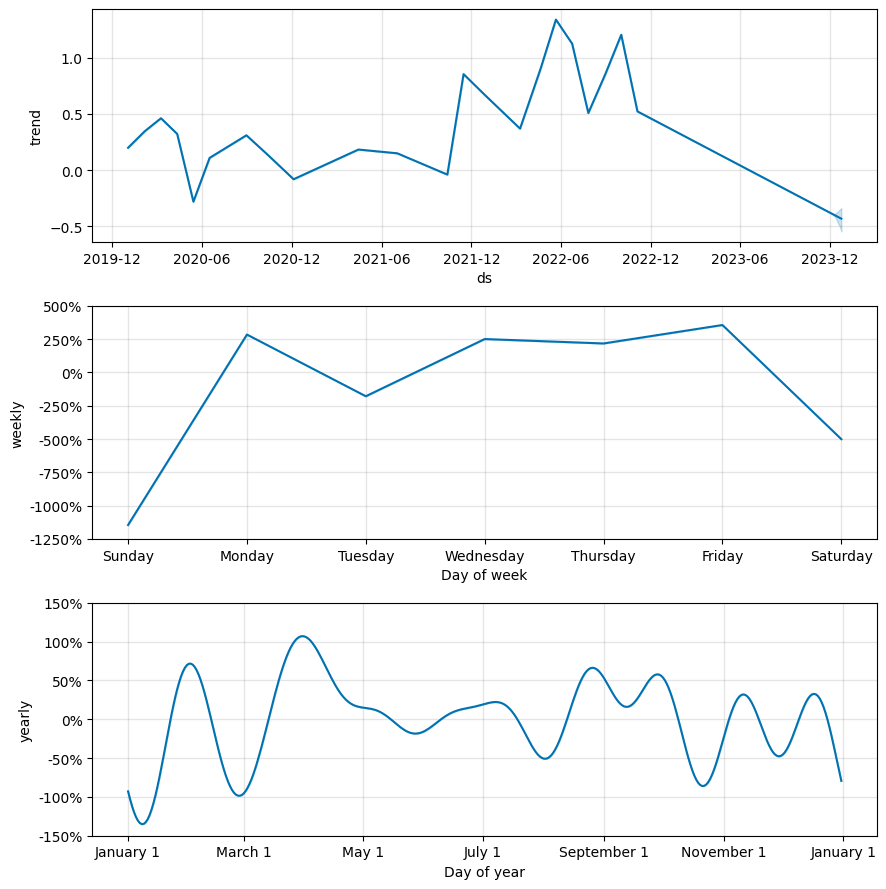

In [92]:
prophet_model.plot_components(forecast)

In [93]:
prophet_ds['y'].describe()

count    1062.000000
mean       -0.011299
std         7.888231
min       -40.000000
25%        -3.000000
50%         0.000000
75%         3.000000
max        41.000000
Name: y, dtype: float64

The mean of booked room in the dataset is 10, here the rmse is 1.7, it means in the temporal window of 20 days the model can at least have an errors of 2 booking,that it is pretty fine for the problem. The result are acceptable and we can dismiss any further investigation.

We've seen in literature especially in [2022,Kaya](https://www.sciencedirect.com/science/article/abs/pii/S0306457321002909) that demand forecasting can be modelled as regression problem with XGBoost.

In [94]:
print(forecast)

             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2020-01-02  0.198106   -8.671582   10.186473     0.198106     0.198106   
1    2020-01-03  0.202463   -8.724491    9.308906     0.202463     0.202463   
2    2020-01-04  0.206819  -10.079727    8.030716     0.206819     0.206819   
3    2020-01-05  0.211176  -12.133992    6.555419     0.211176     0.211176   
4    2020-01-06  0.215533   -8.270369    9.861708     0.215533     0.215533   
...         ...       ...         ...         ...          ...          ...   
1087 2023-12-20 -0.423745  -11.180783    7.191665    -0.492408    -0.355724   
1088 2023-12-21 -0.426045  -11.369262    7.914373    -0.503691    -0.350785   
1089 2023-12-22 -0.428346  -11.286253    7.080459    -0.515683    -0.348337   
1090 2023-12-23 -0.430647   -7.937536   11.737736    -0.531356    -0.343930   
1091 2023-12-24 -0.432947   -4.849374   14.219988    -0.546872    -0.337650   

      multiplicative_terms  multiplicative_terms_lo

In [95]:
demand_ds
start_series = pd.to_datetime(demand_ds['Arrival'].min())
end_series = pd.to_datetime(demand_ds['Arrival'].max())
print(f"Series range {start_series} {end_series}")

Series range 2020-01-02 00:00:00 2023-11-24 00:00:00


## Computing DemandScore

In this contest we've found a method that it can ben generalized to several hotels present in Blastness PMS. 
We train all models with Prophet, compute the score.

In [96]:
total_items = demand_ds['Arrival'].count()
test_size = int(total_items * 0.2)
print(f"Total items {total_items} Test size: {test_size}")

Total items 1062 Test size: 212


In [106]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
start, end = '2022-01-02', '2023-06-01'
index_demand_ds = demand_ds.set_index('Arrival')
booking_series_train = index_demand_ds.loc[start:end]['BookingCount'].asfreq('D')
booking_series_train.fillna(0, inplace=True)
start, end = '2023-06-02', '2023-10-01'
booking_series_test = index_demand_ds.loc[start:end]['BookingCount'].asfreq('D')
am_order = (1,0,0)
seasonal_order = (2, 0, 0, 12)
model = SARIMAX(booking_series_train,order=am_order, seasonal_order=seasonal_order)
model = model.fit()
model.summary()

KeyError: "None of ['Arrival'] are in the columns"

In [ ]:
forcasted =model_fitted.forecast

## Computing Demand Score

For computing the demand score we apply the forecast and than see the trend and from the trend we get the mean we rescale to 100. With this we have defined a process for each hotel series, the algorithm is scattered in two phases: Data Cleaning, Training and Computing the score, basically the following steps. *So for each hotel:
1. Select the hotel booking
2. Clean the data and remove outliers of the last 24 months data.
3. Train the Prophet model using latest data timeframe.
4. Crossvalidate the model 
5. Hyperparameter tuning with Optuna
6. Give to the model a forcast period
7. Check the trend on forecast data.
8. Compute the mean of the trend and rescale to 100.
9. Store the score in JSON in a storage with a timestamp.



In [ ]:
import json
mean_trend =  forecast['trend'].mean() 
demand_score = score = 100/ mean_trend
print(f'Demand score for Hotel008 is: {demand_score}')
outdata = {'score': demand_score, 'hotel_id': '008'}
with open('demand_score_001.json','w') as score:
    json.dump(outdata, score)
    print('Data written on storage')


# Cancellation Score: Analysis on Cancellations

Our customer [Blastness](https://blastness.com) holds all booking inside a Property Management System for his clients. Each booking has three states (classes): *Cancelled, Confirmed, Modified. Our objective is to find an algorithm to compute the cancellation score, based on cancellation forecasting. Most of the recent studies treated as a classification problem. The cancellation factors can depende on hotel, customers, booking and external factors. In our case will leave extrenal factor in the near future. Our goal is to predict the next booking trend for our customers and count the number of cancellation in a future temporal period and compute a score based on the number of cancellations forecasted.
As first step we want to review again the dataset in this classification context, encode categorical data and see results


In [ ]:
hb_dataset.head()

The first thing we might meed for the cancellation score is add a new feature called *CancellationRatio* that take in account the number of cancellations per hotel.


In [ ]:
cancellation_rate = hb_dataset.groupby("HotelId").agg(
    total_bookings=("Status", "size"),          
    cancellations=("Status", lambda x: (x == 0).sum())
)
d = ({
    'HotelId':[],
    'CancRate' :[]
               })
cancellation_rate.reset_index()
for rate in cancellation_rate.iterrows():
    hotel_id = rate[0]
    rate = round(rate[1][1]/rate[1][0],2)
    d['HotelId'].append(hotel_id)
    d['CancRate'].append(rate)
frame = pd.DataFrame(d)
hb_dataset = hb_dataset.merge(frame)


We introduced the cancellation rate inorder to take in account the amount of cancellation per hotel in the global prediction.

We've noticed too many feature and some of them are dependent, our objective is to understand when a reservation is confirmed or cancelled. Let's try to reduce them thru PCA. We want to drop all dates and keep the timestamp since are numerical and spread informations. Let's identify again which are the numerical and which are the categorical before doing the PCA. Principal component analysis (PCA) reduces the number of dimensions in large datasets to principal components that retain most of the original information. It does this by transforming potentially correlated variables into a smaller set of variables, called principal components.

In [ ]:
hb_dataset.describe()

In [ ]:
hb_dataset.dtypes

We notice that we've also categorical variables and some redudant features have been introduced. We will get rid of categorical variables. 

In [ ]:
canc_score_ds = hb_dataset[["Status","BookingChannel","Nights","Total","HotelId","Arrival_Timestamp","CancRate","Departure_Timestamp","Purchase_Timestamp","City","Season"]].copy()
canc_score_ds.sort_values(by=['Purchase_Timestamp','Arrival_Timestamp','Departure_Timestamp'])

In [ ]:
canc_score_ds['Status']

Status will be our target variable since we're interested in Cancelled bookings.

In [ ]:
canc_score_ds.mean()

In [ ]:
canc_score_ds.mode()

In [ ]:
canc_score_ds.median()

In [ ]:
canc_score_ds.isnull().sum()

In [ ]:
canc_score_ds.info()

## Exploratory Data Analysis for Cancellation Score
The first thing that we want to see is the distribution of target variable in our dataset. We notice that it has a binomial, customers in this dataset has a fixed probability of make a booking or not.  The state 1 is booking, 0 cancellatin and 2 modification. We also see that our customers tends to modify the reservation (postpone/change) in small percentuage of cases. Our intent here is to understand how the target variable works and then seen its relationship with other variables.

In [ ]:
y_target = canc_score_ds['Status']
plt.figure(figsize= (10,4))
sns.distplot(y_target)
plt.title("Booking State")
plt.show()

We want to explore the relation between the target variable and the features. We see from the plot distribution are confirmed and once booked a modification is a rare event.

In [ ]:

import plotly.express as px
grouped_data = canc_score_ds.groupby(['Arrival_Timestamp', 'Status']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Arrival_Timestamp", y="Count", color="Status", width=800, height=600,
             labels={"Arrival_Timestamp": "Customer Arrival Timestamp", "Count": "Booking Count", "Status": "Booking Status"},
             title="Distribution of Booking Status per Customer Arrival")
fig.show()

It is interesting to see that there some gaps in the arrival due to the periodic behaviour of the bookings and most of the arrival are confirmed.

Now we want to see the cancellation status and its relationship with the city. It is interesting to see that in Rome all reservation has been confirmed.

In [ ]:

import plotly.express as px
grouped_data = canc_score_ds.groupby(['City', 'Status']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="City", y="Count", color="Status", width=800, height=800,
             labels={"City": "Hotel City", "Count": "Booking Count", "Status": "Booking Status"},
             title="Distribution of Booking Status per City")
fig.show()


Which is the relationship between status and nights? 

In [ ]:
import plotly.express as px
grouped_data = canc_score_ds.groupby(['Nights', 'Status']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Nights", y="Count", color="Status", width=800, height=600,
             labels={"Nights": "Number of Nights", "Count": "Booking Count", "Status": "Booking Status"},
             title="Booking Status by Number of Nights")
fig.show()

As expected all cancelled have 0 night most of the night of arrival range beteen 1 (most of the confirmed), some moodification or variation of 
the booking status appears with customers that have 1 or 2  night, over 5 nights is rare any change of state.

In [ ]:
y_target.describe()

In [ ]:
y_target.skew()

In [ ]:
y_target.kurtosis()

I want to see independently of the hotel the features behave. We see a general binominal behavior that it periodic.

In [ ]:
# Visualize the distribution of each feature
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(12, 9))
features = canc_score_ds.drop(columns=['HotelId','Status'])


# Create a histogram for each feature
num_features = len(features.columns)
num_cols = 3  # Number of columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(15, num_rows * 5))  # Adjust the figure size

for i, feature in enumerate(features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(data=features, x=feature, kde=True)
    plt.title(f'Distribution')
    
plt.tight_layout()
plt.show()

All the date in function of the bookings has a binomial cyclic behavior when there is demand, the behaviour is binomial, and it is independent from the 
cities. There is a gap of data from the Hotel in Rome. Generally most of the confirmed reservations are in Summer.

## Encoding Categorical Features.

In [ ]:
canc_score_ds

In [ ]:
canc_score_ds['Status'].value_counts()

We have 16818 cancellations, 21851  confirmations and only 671 modification. The dataset is unbalanced as we might expect in real world in this business scenario. The dataset is unbalanced and we are going to use Random Forest. The plan is to balance the dataset with SMOTE and then doing the PCA to reduce the dimensionality. Before we need to encode categorical values.

In [ ]:
canc_score_ds

### Create dummies for cities.

In [ ]:
canc_score_ds = pd.concat([canc_score_ds, pd.get_dummies(canc_score_ds[["City"]])], axis=1)
canc_score_ds = canc_score_ds.drop(labels=["City"], axis=1)
canc_score_ds.reset_index()
canc_score_ds

### Encode Booking Channel, Season and HotelId

In [ ]:
channel_names = set(canc_score_ds['BookingChannel'].to_list())
season_names = set(canc_score_ds['Season'].to_list())
hotel_ids = set(canc_score_ds['HotelId'].to_list())
channel_mapper = {}
season_mapper = {}
hotel_id_mapper = {}
for code, name in enumerate(channel_names):
    if name not in channel_mapper:
        channel_mapper[name] = code
for code, season in enumerate(season_names):
    if season not in season_mapper:
        season_mapper[season] = code
for hid, hotelid in enumerate(hotel_ids):
    if hotelid not in hotel_id_mapper:
        hotel_id_mapper[hotelid] = hid
canc_score_ds['SeasonNumeric'] = canc_score_ds['Season'].map(season_mapper)
canc_score_ds['ChannelNumeric'] = canc_score_ds['BookingChannel'].map(channel_mapper)
canc_score_ds['HotelIdNumeric'] = canc_score_ds['HotelId'].map(hotel_id_mapper)
canc_score_ds.drop(labels=['BookingChannel','Season','HotelId'], axis=1, inplace=True)
print(f"Mappings {hotel_id_mapper}")

Now we've all variables categorical and we can try investigate about feature selection. We apply Univariate feature selection to see if the dimensionality can ben reduced.

# Univariate feature selection.
The key idea is to look after thee relationship between features and see if the there are relevant statistical relationship. The feature will be discared
when it doesn't add value to the classification. This method comes from [Muller & Guido](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/) book.

In [ ]:
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

In [ ]:
canc_score_X = canc_score_ds.drop(columns=['Status'])
canc_score_Y = canc_score_ds[['Status']]
num_cols = len(canc_score_X.columns)
print(f"Number of dependent variables {num_cols}")

In [ ]:
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(canc_score_X), 8))
X_w_noise = np.hstack([canc_score_X, noise])
# the first features are from the data set the rest 8 are noise
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, canc_score_Y, random_state=0,test_size=.5)
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print("Number of original features: {}".format(X_train.shape))
print("Number of selected feaures: {}".format(X_train_selected.shape))


We've reduced the features this indicate there is redundancy, as method per dimensionality reduction that fits better with Random Forest we prefere PCA since we believe that we can obtain more.

## Anomaly detection: Outliers.

Outliers are data points that significantly deviate from the majority of the data. They can be caused by errors, anomalies, or simply rare events. Outlies can lead to overfitting. Outliers may lead to overfitting if the model tries to fit them perfectly, thus capturing their noise rather than the actual patterns in the data. We decided to replace outliers with the mean. For detecting outliners in classification problem we use Isolation Forest.
Isolation Forest The algoritm builds a random forest in which each decision tree is grown randomly: at each node, it pickes a feature randomly, the it picks a random threasold value to split the dataset in two. This process is repeated until all instances are isolated. Anomalies are usually far from other instances, so on average they tend to get isolated in fewer steps then normal instances. Once we've indentified the outliners we select and drop them. It's not the best approach since we risk underfit doing but the number is not meaniful in our case, we can drop. Alternative strategy could be repleace with the mean.


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
features = canc_score_ds.drop(columns=['Status'])
sca = StandardScaler()
X_train = sca.fit_transform(features)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
canc_score_ds['outlier'] = iso_forest.fit_predict(X_train)
outliers = canc_score_ds[canc_score_ds['outlier'] == -1]
inliers = canc_score_ds[canc_score_ds['outlier'] == 1]
# Display the number of outliers detected
print(f"Number of outliers detected: {len(outliers)}")


In [ ]:
# Plot the inliers and outliers
plt.figure(figsize=(12, 8))
plt.scatter(canc_score_ds.index, canc_score_ds['Arrival_Timestamp'], c=canc_score_ds['outlier'], cmap='coolwarm', edgecolor='k', s=50)
plt.title('Isolation Forest: Outliers Detection per Arrival Timestamp')
plt.show()


In [ ]:
canc_score_ds.count()

We decide to remove and drop the outliers instead of replacing with the median. We lose only 10% of infromation on more than 40000 bookings.

In [ ]:
canc_score_ds = canc_score_ds.drop(columns=['outlier'])
canc_score_ds.count()


Everything looks good, but I am interested to see if there is a kind of unbalancing of booking type and if we want to use SMOTE again. We can plot the status and see what happens.

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
type_counts = canc_score_ds['Status'].value_counts()
type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Booking State')
plt.xlabel('Booking State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



## Rebalancing with SMOTE

The classes are unbalanced so to make our prediction better with Random Forest despite their properties make sensitive to imbalanced dataset.

In [ ]:
!pip install imbalanced-learn

In [ ]:
X = canc_score_ds.drop(columns=['Status']) 
y = canc_score_ds['Status']

In [ ]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
canc_score_ds = pd.DataFrame(X_resampled, columns=X.columns)
canc_score_ds['Status'] = y_resampled

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
type_counts = canc_score_ds['Status'].value_counts()
type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution Booking State')
plt.xlabel('Booking State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Data augumentation worked fine, now our dataset is balanced.

### Correlation Matrix.
We want to see now how are correlated the features and how they relate.

In [ ]:
corr_matrix = canc_score_ds.corr()
# Create a heatmap
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# Set the title for the heatmap
plt.title('Correlation Heatmap')
# Display the heatmap
plt.show()

The interesting things a weak correlation with the season and with the city and our tartget. The city and the hotel are not such important. Let see if change with balancing the dataset. Total is the total revenue and it obviously. Now we scale the training data 

In [ ]:
X_features = canc_score_ds.drop(columns=['Status'])
y_target = canc_score_ds['Status']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                        test_size=0.3, random_state=42)

# Principal Component Analysis
Now we prepare ourselves on PCA, later we use hyperparameters tuning and random forest to pack together with cross validation., creating a pipeline that will allow to instrumentally fit better.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_features.shape

We want to reduce the dimensionality of the dataset but in appropriate way choosing the appropriate number of dimesion to up a given expected_variance_ratio for each princial component,let's say 95 per cent. So we split the data set, doing the fit and get the appropriate dimensions. Actually we're able to obtain the same result that we obtained with Univariate feature selection: we're able to have 11 features from 15. 

In [ ]:
sca = StandardScaler()
X_train = sca.fit_transform(X_train)
X_test = sca.fit_transform(X_test)

In [ ]:
# project the model on two dimension in order to be able to visualize it.
# split the training set in two
from sklearn.decomposition import PCA
n_cols = X_train.shape[1]
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
# comutalive sum of the variance ration of each component
print("Dimensionality reduce from {} to {}".format(n_cols,pca.n_components_))

## Cancellation Score Model: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
base_line_model_clf = RandomForestClassifier(n_estimators=20, random_state=42)
base_line_model_clf.fit(X_reduced, y_train)



In [ ]:
cross_val_score(base_line_model_clf, X_reduced, y_train, cv=3, scoring="accuracy")

The accuracy is pretty much good. Let's do hyperparameter tuning and classification in a pipeline. Then we will add crossvalidation to same pipeline, later first we want to see results.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))
clf

In [ ]:
param_distrib = {
    "pca__n_components": np.arange(2, 15),
    "randomforestclassifier__n_estimators": np.arange(20, 100),
    "randomforestclassifier__max_depth": [3, 6, 10], 
    "randomforestclassifier__criterion": ['gini', 'entropy'], 
    "randomforestclassifier__max_features": ['sqrt', 'log2']}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=5, cv=3, random_state=42)
tuned_clf = rnd_search.fit(X_train, y_train)

In [ ]:
print ("Paramters found: {}".format(rnd_search.best_params_))

Notice the sensitive variations on dimensions for PCA. The next step is to create a pipeline that it is able to cross-validate itself with PCA 
and RandomForest.

In [ ]:
y_pred = tuned_clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Crossvalidation here eliminate overfitting. The accuracuy is still good enough.

In [ ]:
cross_val_score(tuned_clf, X_train, y_train, cv=3, scoring="accuracy")

## Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred) 
# Then just plot it: 
disp.plot() 
# And show it: 
plt.show()

Just 90 per cent of matches. Let's crossvalidate to avoid overfitting Stratified KFold cross validation as parameter to the pipeline. Stratified crossvalidation mantains the class distribution during the splitting and reduce overfitting. The interesting part of this graphs is that the forecasting error of caclellation is good. 


In [ ]:
from sklearn.model_selection import StratifiedKFold
# For classificatoion problems like this mantains the original distribution
skf = StratifiedKFold(n_splits=5)
param_distrib = {
    "pca__n_components": np.arange(2, 15),
    "randomforestclassifier__n_estimators": np.arange(20, 100),
    "randomforestclassifier__max_depth": [3, 6, 10], 
    "randomforestclassifier__criterion": ['gini', 'entropy'], 
    "randomforestclassifier__max_features": ['sqrt', 'log2']}
# we prefer RanndomizedSarchCV becasue G
# 3 iterations should be enough
rnd_search = RandomizedSearchCV(clf, param_distrib, cv=skf, random_state=42,verbose=3)
tuned_clf_v2 = rnd_search.fit(X_train, y_train)

Let see now the numbers:

In [ ]:
y_pred = tuned_clf_v2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred) 
# Then just plot it: 
disp.plot() 
# And show it: 
plt.show()

### Singular Vector Machine: Cancellation Score.
It is interesting to see if a cross validated SVM perform better.

In [ ]:
from sklearn.svm import SVC
svm_pipeline = make_pipeline(PCA(random_state=42), SVC(kernel='linear'))
cv_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=skf, scoring='accuracy')
cv_scores

In [ ]:
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
              "pca__n_components": np.arange(2, 15),
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'svc__kernel': ['rbf']}  
# Set up the GridSearchCV object
grid_search = RandomizedSearchCV(svm_pipeline, param_grid, cv=skf,n_iter=3,verbose=5)
tuned_svm_model = grid_search.fit(X_train, y_train)
y_pred = tuned_svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=['Random Forest', 'Accuracy Cross Validated Random Forest','Accuracy CrossValidated SVC']),
                 cells=dict(values=[[0.95], [0.92],[0.94]]))])
fig.show()

# Compute Cancellation Score.
As you can see in the table the SVC model that we trained performs better, we prefer in term of deployability and performance (time to train) to use Random Forest and the model that we've trained. How we compute the cancellation score. The process is do prediction on test data and count the number of cancellations. For easy to proceed we use our test_data that we've splitted, ideally should be most recent data che comes from the user, rescaled and cleaned, where the feature HotelId is crafted explicit. Let's try to create function **compute_canc_score** that compute the cancellation score for each customers and store in a JSON file


In [ ]:
import json
def compute_canc_score():
    sca = StandardScaler()
    score_dict = {}
    for k in range(0,10):
        canc_score_per_hotel = canc_score_ds[(canc_score_ds['HotelIdNumeric'] == k)].copy()
        y = canc_score_per_hotel['Status']
        X = canc_score_per_hotel.drop(['Status'],axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=.5)
        X_train = sca.fit_transform(X_train)
        X_test = sca.fit_transform(X_test)
        y_pred = tuned_svm_model.predict(X_test)
        total = y_pred.shape[0]
        num_zeros = np.count_nonzero(y_pred)
        num_id = f'00{k}' if k < 10 else f'0{k}'        
        hb_ds_per_hotel = canc_score_compute[(canc_score_compute['HotelId'] == num_id)].copy()
        hotel_bookings = hb_ds_per_hotel['Status'].count()
        past_cancellations = hb_ds_per_hotel[(hb_ds_per_hotel['Status']==0)]['Status'].count() 
        past_score = past_cancellations / hotel_bookings if hotel_bookings > 0 else 0
        score = (total - num_zeros)/total * past_score
        print(f'HotelNumericId: {k} Reservations {hotel_bookings} Cancellations {past_cancellations} Cancellation Score: {score}')
        score_dict[num_id] = score
    return score_dict
score_dict = compute_canc_score()
with open('cancellation_score.json','w') as sc:
    json.dump(score_dict,sc)

We've found a way to compute easily using Machine Learning and historical data score per cancellation, a score that will allow revenue managers to classify Hotel performance.

# <b>Review Score</b> using BERT Sentiment Analysis over Tripadvisor Reviews.

<p>Hotel performance in terms of revenue depends stricly from online reputation (cit), so our goal in designing <b>HotelRank</p> algorithm is to analyze reviews about our customers hotel and provide an unique score to put a linear factor in HotelRank. We can name that score as <i>review score</i>.</p>
<p><B>ReviewScore = Hotel_Rating - (0.5 * #number_negative review) + (0.25 * number of positive review)</B></p>
<p>Here we emphasize the idea that is better not having negitive than positive reviews. To compute this formula we need we are in need to perform sentiment analysis over hotel reviews.</p><p>In case the <b>ReviewScore</b> is negative we assume that his weight to HotelRank is 0</p>


The state-of-the-art sentiment analysis can be accomplished by fine-tuning pretrained BERT models with sentiment-analysis datasets. Fine-tuning is accomplished by further training a pretrained model for a limited number of epochs and with a reduced learning rate. We have collected the review using a scraper that we've coded in Go programming Language.

In [ ]:
!pip install tensorflow
!pip install keras
!pip install tf-keras 
!export TF_USE_LEGACY_KERAS=1

The first thing that we need is to download all reviews using our Tripadvisor scraper. For having good reviews we've devoloped a scraper in Go Programming Language targeted to fetch the reviews and creating a csv file. Our objective is using pretrained BERT, fit it with Internet Movied Database data and do sentiment analysis over our review. Reviews score will be computed as weighted combination of the reviews, giving more weight to negative review.

In [ ]:
import glob
import os
import os.path
import pandas as pd
DATA = os.getcwd()
review_files = glob.glob('reviewscore/*.csv')
review_dict = {}
for review in review_files:
    base_file = os.path.basename(review)
    code ='0'+base_file.split('_')[1].split('.')[0]
    review_dict[code] = os.path.join('./reviewscore',base_file)
print(review_dict)
    

In [ ]:
hotel_08 =  pd.read_csv(review_dict['008'])

In [ ]:
hotel_08.head()

In [ ]:
hotel_08.isnull().sum()

In [ ]:
hotel_08.describe()

In [ ]:
import plotly.express as px
grouped_data = hotel_08.groupby(['Year', 'Rating']).size().reset_index(name='Count')

fig = px.bar(grouped_data, x="Year", y="Count", color="Rating", width=800, height=600,
             labels={"Review Year": "Customer Arrival Timestamp", "Count": "Number Review", "Rating": "Rating"},
             title="Distribution of TripAdvisor Review Rating per Year")
fig.show()

Blasteness most important customer performed quite well in terms of online reputation. Most of the review rating are yellow. 
The review score should also follow this trend to be accurate.

In [ ]:
from datasets import load_dataset

imdb = load_dataset('imdb')
imdb

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(samples):
    return tokenizer(samples['text'], truncation=True)

tokenized_imdb = imdb.map(tokenize, batched=True)

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

train_data = tokenized_imdb['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

validation_data = tokenized_imdb['test'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

In [ ]:
MODEL_NAME = 'distilbert-base-cased'
BATCH_SIZE=10
N_EPOCHS=5

In [ ]:

from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.compile(Adam(learning_rate=2e-5), metrics=['accuracy'])
hist = model.fit(train_data, validation_data=validation_data, epochs=N_EPOCHS)



Plot the training and accuracy.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
pd.DataFrame(hist.history).plot(figsize=(8,5), xlim=[0,49], ylim=[0,1], grid=True, xlabel='Epoch', style=['r--','r--.','b-','b-*'])
plt.show()


In [ ]:


def review_text(text, tokenizer, model):
    tokenized_text = tokenizer(text, padding=True, truncation=True, return_tensors='tf')
    prediction = model(tokenized_text)
    return tf.nn.softmax(prediction[0]).numpy()[0][1]



In [ ]:
def compute_review_score(hotel_df, tokenizer, model):
    review_score = 0 
    negative = 0
    positive = 0
    rating_cumulative = 0
    count = 0
    for row in hotel_df.iterrows():
        count = count + 1
        text = row['Text']
        score = review_text(text, tokenizer, model)
        if score < 0.5:
            negative = negative + 1
        else:
            positive = positive + 1
        rating = rating + float(row['Rating'])
    
    review_score = rating/count - 0.5 * (negative/count) + 0.25 * (positive/count)
    return review_score

print('Review score for hotel 008: {}'.format(compute_review_score(hotel_008, tokenizer, model)
    